<div style="text-align: center;">
    <h1>Applied Data Science</h1>
    <h3><em>Spring 2025</em></h3>
    <h2>Implementing Convolutional Neural Network and Neural Style Transfer from scratch</h2>
    <hr style="width:100%;">
    <h3>AmirReza Azari</h3>
    <p><em>Student ID: 99101087</em></p>
</div>

---

## Section 1 - CNN

Convolutional Neural Networks (CNNs) are powerful tools in the field of Computer Vision. You have already seen Multi-Layer Perceptrons (MLPs) and learned how forward and backward passes work in them. In this section, we will build a simple convolutional layer from scratch to clearly understand how it operates behind the scenes. Once we grasp the underlying mechanics, we can then rely on PyTorch’s `Conv2D` layer for the rest of the project with confidence in how convolutions actually work.


__Forward Pass__:

In the forward pass, the convolution operation is applied to the input image. The basic operation can be written as:

$$
\text{output}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{input}[i+k, j+l] \times \text{kernel}[k, l]
$$

The following image illustrates a sample convolution with a $3 \times 3$ kernel:
<div style="text-align:center;">
  <img src="./Images/Conv.gif" />
</div>

This example is meant to build intuition. For the forward pass you implement, remember that the kernel must be convolved across all $C$ channels of the input image. The resulting output shape will be:

$$
(N, H_{out}, W_{out})
$$

where the spatial dimensions are calculated as:

$$
H_{out} = \frac{H_{in} + 2 \times \text{padding} - HH}{\text{stride}} + 1
$$
$$
W_{out} = \frac{W_{in} + 2 \times \text{padding} - WW}{\text{stride}} + 1
$$

Here:
- $HH$ and $WW$ are the kernel’s height and width  
- __stride__ is the step size of the kernel  
- __padding__ is the number of zeros added around the input  

<div style="display: flex; justify-content: center; gap: 30px; text-align: center;">
  <div>
    <img src="./Images/no_padding_no_strides.gif" width="300"/>
    <p>pad = 0, stride = 1</p>
  </div>
  <div>
    <img src="./Images/padding_strides.gif" width="335"/>
    <p>pad = 1, stride = 2</p>
  </div>
  <div>
    <img src="./Images/same_padding_no_strides.gif" width="300"/>
    <p>pad = 1, stride = 1</p>
  </div>
</div>

__Backward Pass__:

In the backward pass, we compute the gradients of the output with respect to the input image, the kernel weights, and the bias. These gradients are essential for optimization, since they are used to update the kernel weights during training (similar to how gradients were used in MLPs with gradient descent).

The quantities we need are:
- $d_x$: gradient with respect to the input
- $d_w$: gradient with respect to the kernel weights
- $d_b$: gradient with respect to the bias

They are calculated as follows:

$$
dx_{padded}[n, :, i \cdot stride : i \cdot stride + HH,\ j \cdot stride : j \cdot stride + WW] \;+=\; w[f] \times dout[n, f, i, j]
$$

$$
dw_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1}
x_{padded}[n, :, i \cdot stride : i \cdot stride + HH,\ j \cdot stride : j \cdot stride + WW] \times dout[n, f, i, j]
$$

$$
db_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} dout[n, f, i, j]
$$

Here:
- $dout$ is the gradient flowing from the next layer  
- $HH$ and $WW$ are the kernel’s height and width  
- $stride$ determines the step size of the convolution  

The figure below illustrates the idea of the backward pass more clearly:

<p align="center">
  <img src="./Images/backprop_cs231n.png" alt="Backward pass illustration" />
</p>

Now, let's start:

In [1]:
import numpy as np

class MyConv:
    def __init__(self, stride, padding):
        self.stride = stride
        self.padding = padding

    def forward(self, x, w, b):
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        H_out = 1 + (H + 2 * self.padding - HH) // self.stride
        W_out = 1 + (W + 2 * self.padding - WW) // self.stride
        x_pad = np.pad(x, ((0,), (0,), (self.padding,), (self.padding,)), mode='constant')
        out = np.zeros((N, F, H_out, W_out))
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        out[n, f, i, j] = np.sum(
                            x_pad[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] * w[f]
                        ) + b[f]
        self.cache = (x, w, b, x_pad)
        return out

    def backward(self, dout):
        x, w, b, x_padded = self.cache
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        _, _, H_out, W_out = dout.shape
        dx_padded = np.zeros_like(x_padded)
        dw = np.zeros_like(w)
        db = np.zeros_like(b)
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        dw[f] += x_padded[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] * dout[n, f, i, j]
                        dx_padded[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] += w[f] * dout[n, f, i, j]
                        db[f] += dout[n, f, i, j]
        dx = dx_padded[:, :, self.padding:H + self.padding, self.padding:W + self.padding]
        return dx, dw, db


In [2]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / np.maximum(1e-8, np.abs(x) + np.abs(y)))

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv = MyConv(stride=2, padding=1)
out = conv.forward(x, w, b)

correct_out = np.array([
    [[[-0.08759809, -0.10987781],
      [-0.18387192, -0.2109216 ]],
     [[ 0.21027089,  0.21661097],
      [ 0.22847626,  0.23004637]],
     [[ 0.50813986,  0.54309974],
      [ 0.64082444,  0.67101435]]],
    [[[-0.98053589, -1.03143541],
      [-1.19128892, -1.24695841]],
     [[ 0.69108355,  0.66880383],
      [ 0.59480972,  0.56776003]],
     [[ 2.36270298,  2.36904306],
      [ 2.38090835,  2.38247847]]]
])

print('Testing conv_forward_naive')
print('difference:', rel_error(out, correct_out))


Testing conv_forward_naive
difference: 2.2121476417505994e-08


In [4]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]

        x[ix] = oldval + h
        pos = f(x).copy()

        x[ix] = oldval - h
        neg = f(x).copy()

        x[ix] = oldval
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)

        it.iternext()

    return grad


In [5]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2)
dout = np.random.randn(4, 2, 5, 5)

conv = MyConv(stride=1, padding=1)

dx_num = eval_numerical_gradient_array(lambda x_: conv.forward(x_, w, b), x, dout)
dw_num = eval_numerical_gradient_array(lambda w_: conv.forward(x, w_, b), w, dout)
db_num = eval_numerical_gradient_array(lambda b_: conv.forward(x, w, b_), b, dout)

out = conv.forward(x, w, b)
dx, dw, db = conv.backward(dout)

print("Testing conv_backward_naive function")
print("dx error:", rel_error(dx, dx_num))
print("dw error:", rel_error(dw, dw_num))
print("db error:", rel_error(db, db_num))


Testing conv_backward_naive function
dx error: 1.4824406059894475e-08
dw error: 1.1223195678501481e-09
db error: 2.601556749736694e-12


---

In this section, we visualize the results of the convolution operation. We will use two sample images (located in `Images/Sample`) and apply our `MyConv` class to perform various convolutions. This will allow us to see how different filters affect an image.


In [6]:
from PIL import Image

first_img, second_img, third_img, fourth_image = Image.open("./Images/Sample/green_car.jpg"), Image.open(
    "./Images/Sample/env_picture.jpg"), Image.open("./Images/Sample/house.jpg"), Image.open("./Images/Sample/ocean.jpg")

first_img = first_img.resize((256, 256))
second_img = second_img.resize((256, 256))
third_img = third_img.resize((256, 256))
fourth_image = fourth_image.resize((256, 256))

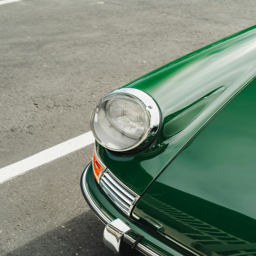

In [7]:
first_img

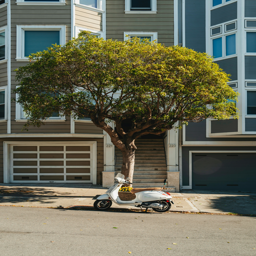

In [8]:
second_img

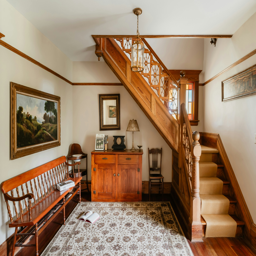

In [9]:
third_img

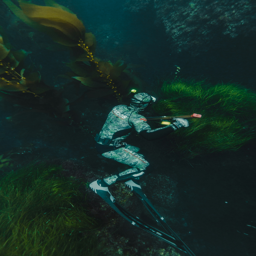

In [10]:
fourth_image

Convolutions have many interesting applications in image processing. For example, you can highlight edges in an image by applying an edge detection kernel, or use specific kernels to produce effects like grayscale or blurring. Below are a few common examples:

__Edge Detection (Sobel Operator)__

The Sobel operator is a well-known method for edge detection. It uses two kernels: one for vertical edges and one for horizontal edges.

$$
\text{Sobel}_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
\text{Sobel}_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$


__Grayscale Conversion__

To approximate a grayscale image, you can apply separate kernels across the Red, Green, and Blue channels, then combine the results:

$$
\text{Grayscale\_R} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.3 & 0 \\
0 & 0 & 0
\end{bmatrix}
\quad
\text{Grayscale\_G} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.6 & 0 \\
0 & 0 & 0
\end{bmatrix}
\quad
\text{Grayscale\_B} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

Each kernel is convolved with its corresponding channel before combining them into the grayscale output.


__Blurring (Gaussian Blur)__

Blurring smooths an image by averaging pixel values in a neighborhood. A common choice is the Gaussian Blur kernel:

$$
\text{Gaussian\_Blur} = \frac{1}{16} \times
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$


In [11]:
import numpy as np

# Kernels
Sobelx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

Sobely = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])

Grayscale_across_R = np.array([[0, 0, 0],
                               [0, 0.3, 0],
                               [0, 0, 0]])

Grayscale_across_G = np.array([[0, 0, 0],
                               [0, 0.6, 0],
                               [0, 0, 0]])

Grayscale_across_B = np.array([[0, 0, 0],
                               [0, 0.1, 0],
                               [0, 0, 0]])

Gaussian_Blur = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) / 16


In [12]:
img_size = 256

x = np.stack([
    np.array(first_img).transpose(2, 0, 1),
    np.array(second_img).transpose(2, 0, 1),
    np.array(third_img).transpose(2, 0, 1),
    np.array(fourth_image).transpose(2, 0, 1)
])

w = np.zeros((4, 3, 3, 3))
w[0, 0], w[0, 1], w[0, 2] = Grayscale_across_R, Grayscale_across_G, Grayscale_across_B
w[1] = Sobelx
w[2] = Sobely
w[3] = Gaussian_Blur

b = np.array([0, 128, 128, 0])

conv = MyConv(stride=1, padding=1)
out = conv.forward(x, w, b)
print(out.shape)  # (4, 4, 256, 256)

(4, 4, 256, 256)


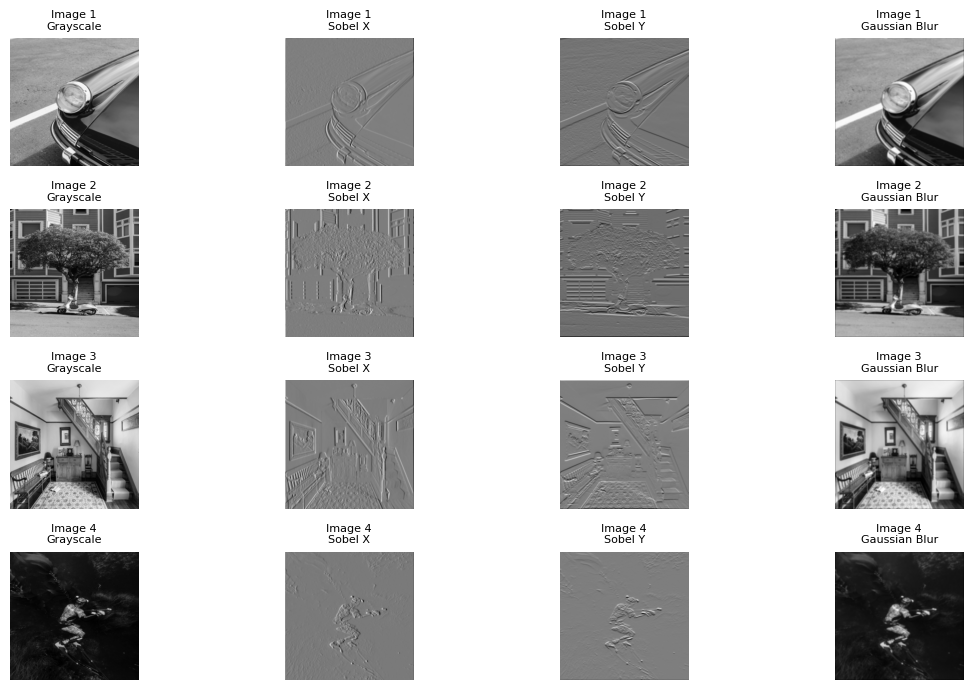

In [13]:
import matplotlib.pyplot as plt

num_images, num_channels, H, W = out.shape
channel_labels = ['Grayscale', 'Sobel X', 'Sobel Y', 'Gaussian Blur']

plt.figure(figsize=(12, 7))

for i in range(num_images):
    for j in range(num_channels):
        idx = i * num_channels + j + 1
        plt.subplot(num_images, num_channels, idx)
        plt.imshow(out[i, j], cmap='gray')
        plt.title(f'Image {i+1}\n{channel_labels[j]}', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()


## Section 2 - NST

In this part, we are going to implement a famous technique in the field of _Computer Vision_ called **Neural Style Transfer**. This technique is used to apply the style of a specific image to another image. For example, you can apply the style of a famous painting to your photo! Let's get started!

## Libraries

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [15]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
torch.set_default_device(device)
device

device(type='cuda')

In this part, I will load the content and style images and preprocess them. The preprocessing steps include resizing the images to a specific size, normalizing them, and converting them into PyTorch tensors. I will use `torchvision.transforms` to handle these tasks.


In [16]:
img_size = 512 if not device == "cpu" else 256

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [17]:
style_image_path = "/content/Images/Neural_Transfer/orange.jpg"
content_image_path = "/content/Images/Neural_Transfer/content.jpg"

# Load and preprocess the style image
style_image = Image.open(style_image_path).convert('RGB')
style_image = transform(style_image).unsqueeze(0).to(device)

# Load and preprocess the content image
content_image = Image.open(content_image_path).convert('RGB')
content_image = transform(content_image).unsqueeze(0).to(device)

# Print the sizes of the preprocessed images
print("Style image size:", style_image.size())
print("Content image size:", content_image.size())

Style image size: torch.Size([1, 3, 512, 512])
Content image size: torch.Size([1, 3, 512, 512])


Here, I will implement a helper function to display the images (which are currently in the form of PyTorch tensors) in the notebook. I will use `torchvision.transforms.ToPILImage` to convert a tensor into a PIL image.


In [18]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def imshow(tensor, title=None, normalized=True):
    unloader = transforms.ToPILImage()
    if normalized:
        tensor = unnormalize(tensor)
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

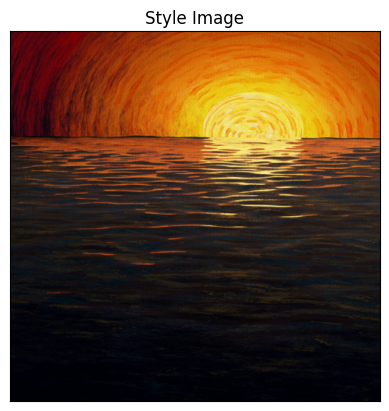

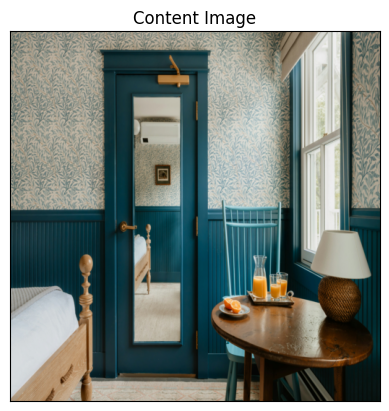

In [19]:
imshow(style_image, title='Style Image')
imshow(content_image, title='Content Image')

### VGG19 Model

One of the important parts of Neural Style Transfer is using a pre-trained model to extract features from the content and style images. Here, I will use a pre-trained VGG19 model to extract features from the images. I will use `torchvision.models.vgg19` to load the model and freeze its weights to prevent them from updating during the optimization process.


But what is VGG model? Let's see with a simple experiment:

In [20]:
import certifi
import os

os.environ['SSL_CERT_FILE'] = certifi.where()

Here, I will load the `VGG19` model from `torchvision.models` and examine its architecture. I may need to store the `features` and `classifier` parts separately, as I will discuss both of these components.


In [21]:
import torch
from torchvision.models import vgg19


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_model = vgg19(pretrained=True).to(device)

vgg_model_features = vgg_model.features.eval()
vgg_model_classifier = vgg_model.classifier.eval()

vgg_model_features.to(device)
vgg_model_classifier.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 139MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
import torchsummary

torchsummary.summary(vgg_model_features, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

# VGG Model Overview

The **VGG model** (e.g., VGG-16, VGG-19) is a deep **Convolutional Neural Network (CNN)** architecture created by the **Visual Geometry Group (VGG), Oxford University**.  
It is mainly used for **image classification** and **transfer learning**.

---

## Architecture Components

### 1. `features` (Convolutional Base)
- Made up of **convolutional layers** and **max-pooling layers**.
- Purpose: **extract hierarchical features** from images.
  - Early layers → detect **edges, corners, simple textures**.  
  - Middle layers → capture **shapes, motifs, object parts**.  
  - Deeper layers → represent **high-level object features**.  
- The output is a set of **feature maps**.

Think of this as the **“eyes” of the network**.

---

### 2. `classifier` (Fully Connected Head)
- Made up of **fully connected (dense) layers** at the end of the network.
- Takes the flattened feature maps from the `features` part.
- Purpose: **map features → class probabilities**.
  - Combines information across the whole image.
  - The final layer usually uses **softmax** for multi-class classification.

Think of this as the **“brain” of the network**.

---

## Flow of Data (Simplified)

Input Image → [features] Convs + Pooling → Feature Maps → Flatten → [classifier] Dense Layers → Output Class

---

## Why It’s Useful
- **Image classification** (originally on ImageNet dataset with 1000 classes).
- **Transfer learning**: pretrained `features` can be reused on new tasks (object detection, medical imaging, etc.), while `classifier` is replaced/adapted.
- Simplicity + depth = strong baseline model in computer vision.

---

**Summary**:
- `features` = **extract visual patterns (low → high level)**  
- `classifier` = **decide which class the image belongs to**

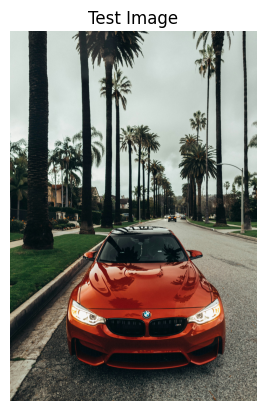

Predicted class number: 817


In [23]:
vgg_test_image = Image.open("/content/Images/Neural_Transfer/car.jpg")

plt.imshow(vgg_test_image)
plt.title("Test Image")
plt.axis('off')
plt.show()

preprocess_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess_vgg(vgg_test_image)
input_batch = input_tensor.unsqueeze(0).to(device)


with torch.no_grad():
    output = vgg_model(input_batch)

# Print the predicted class number
predicted_class = output.argmax(dim=1).item()
print("Predicted class number:", predicted_class)

As you can see, the output of the classifier is an integer. This integer is actually the **class number** in _Image Net_ dataset. Let's get the name of the class:

In [24]:
import requests

class_idx = requests.get(
    "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
).json()

# Get the class name
class_name = class_idx[predicted_class]

print(f"Predicted class: {class_name}")

Predicted class: sports car


Now that we understood the architecture of VGG, and also the output of its classifier, it's time to extract features from the images! And see what's going on in the feature maps!

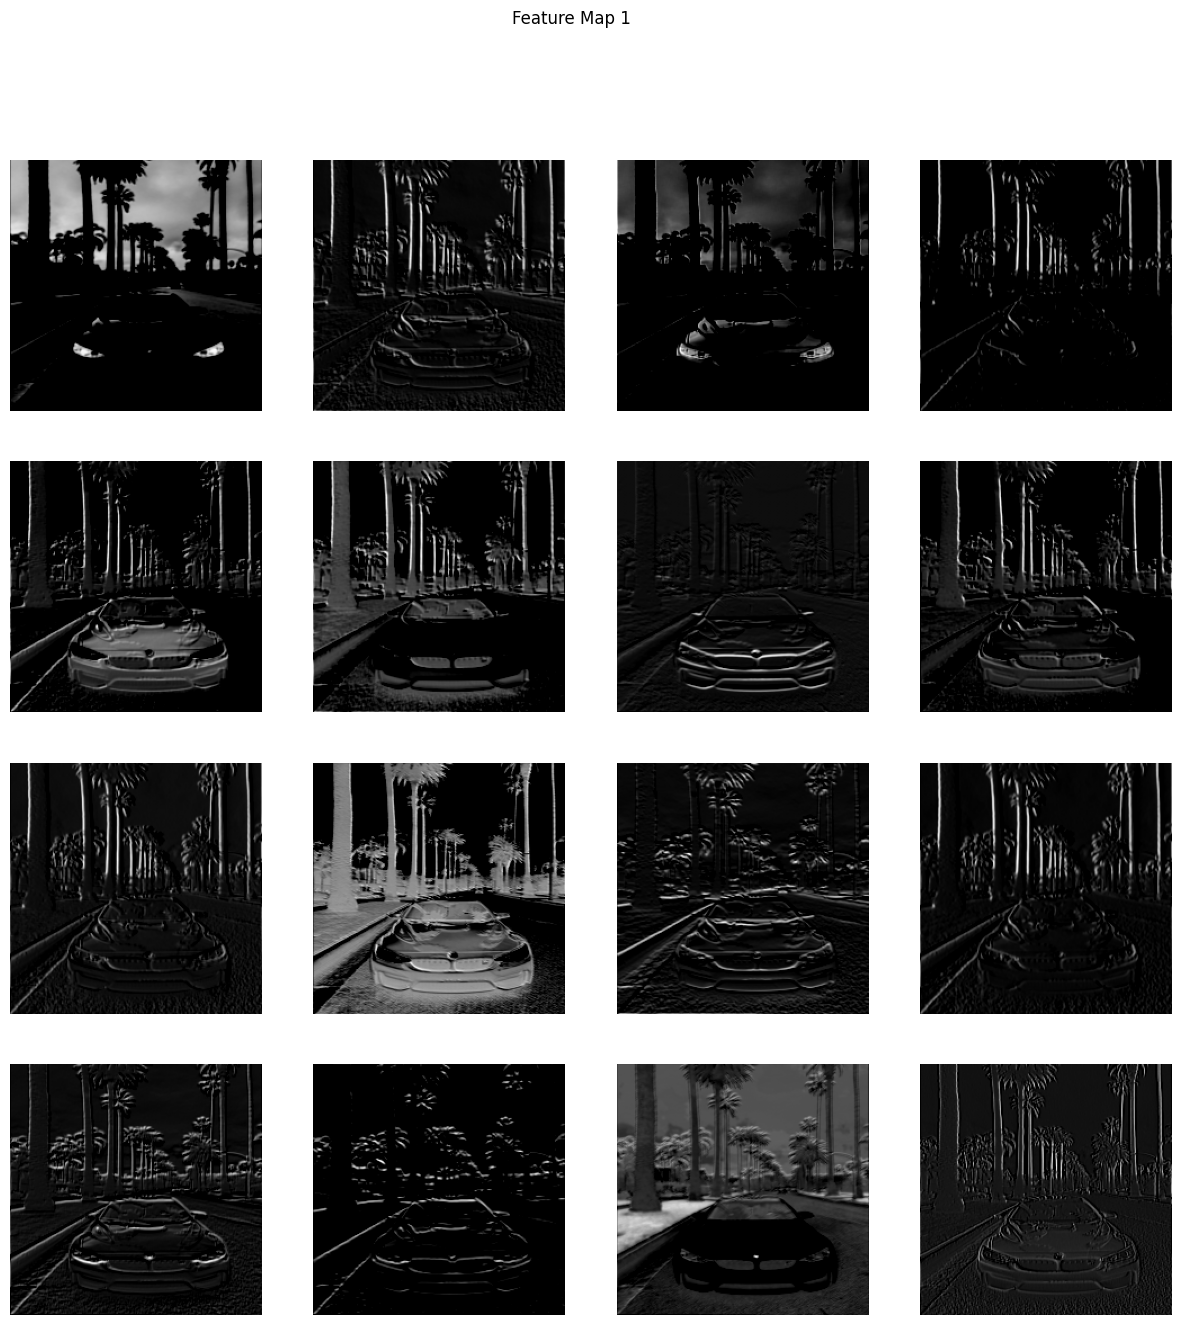

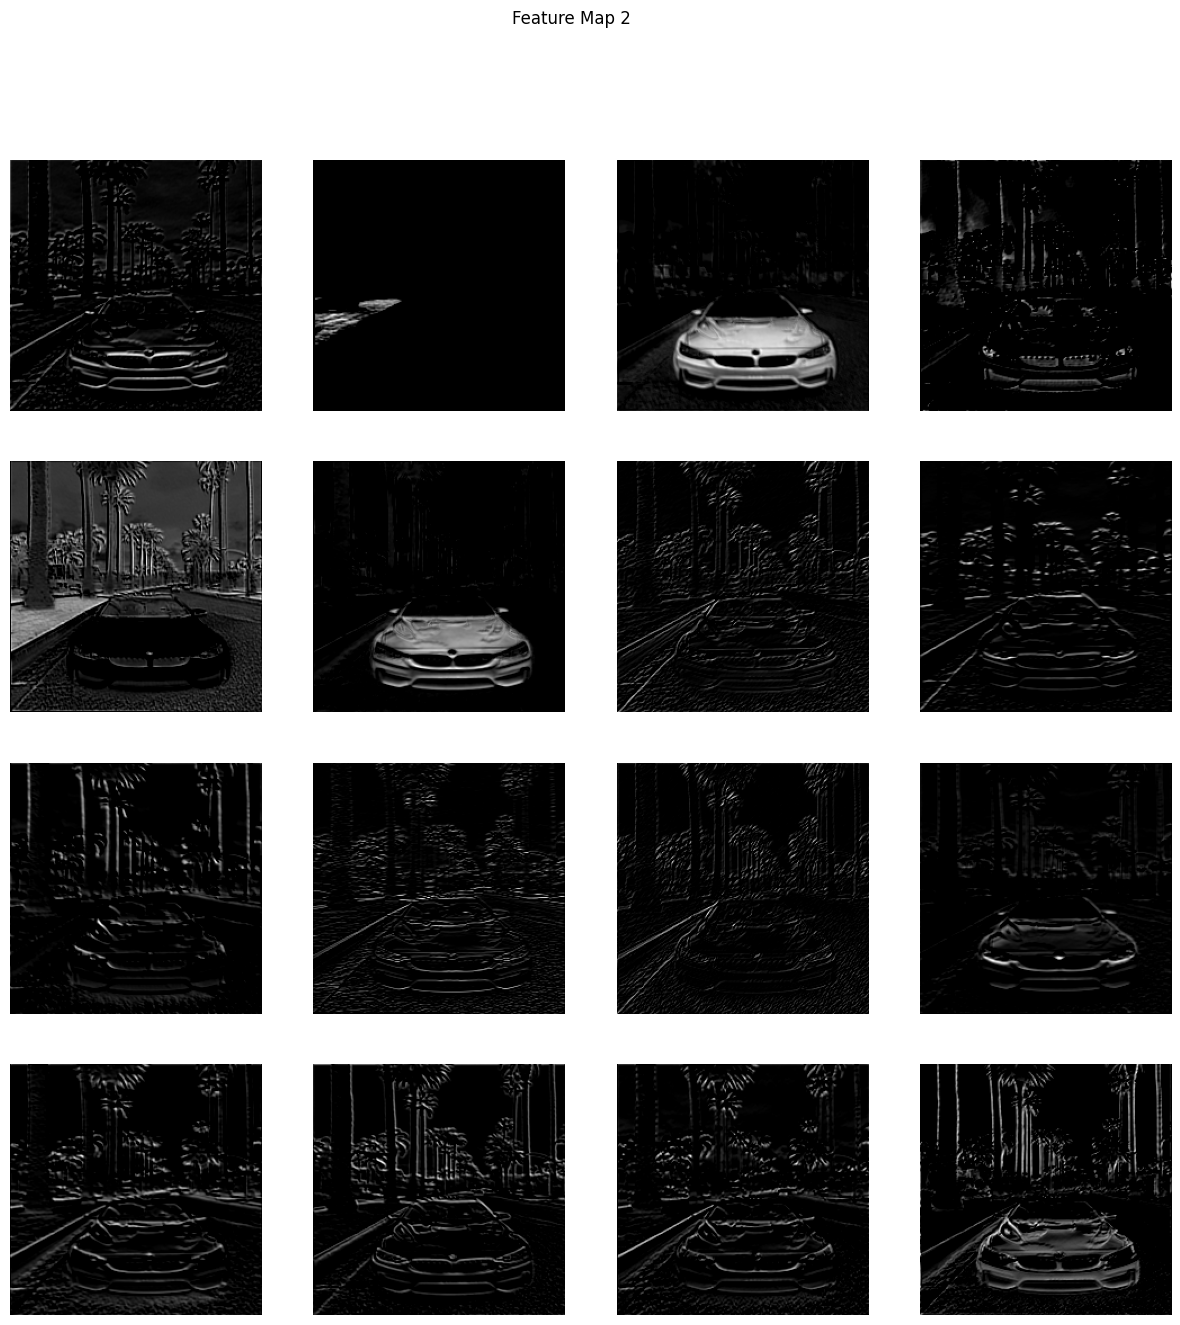

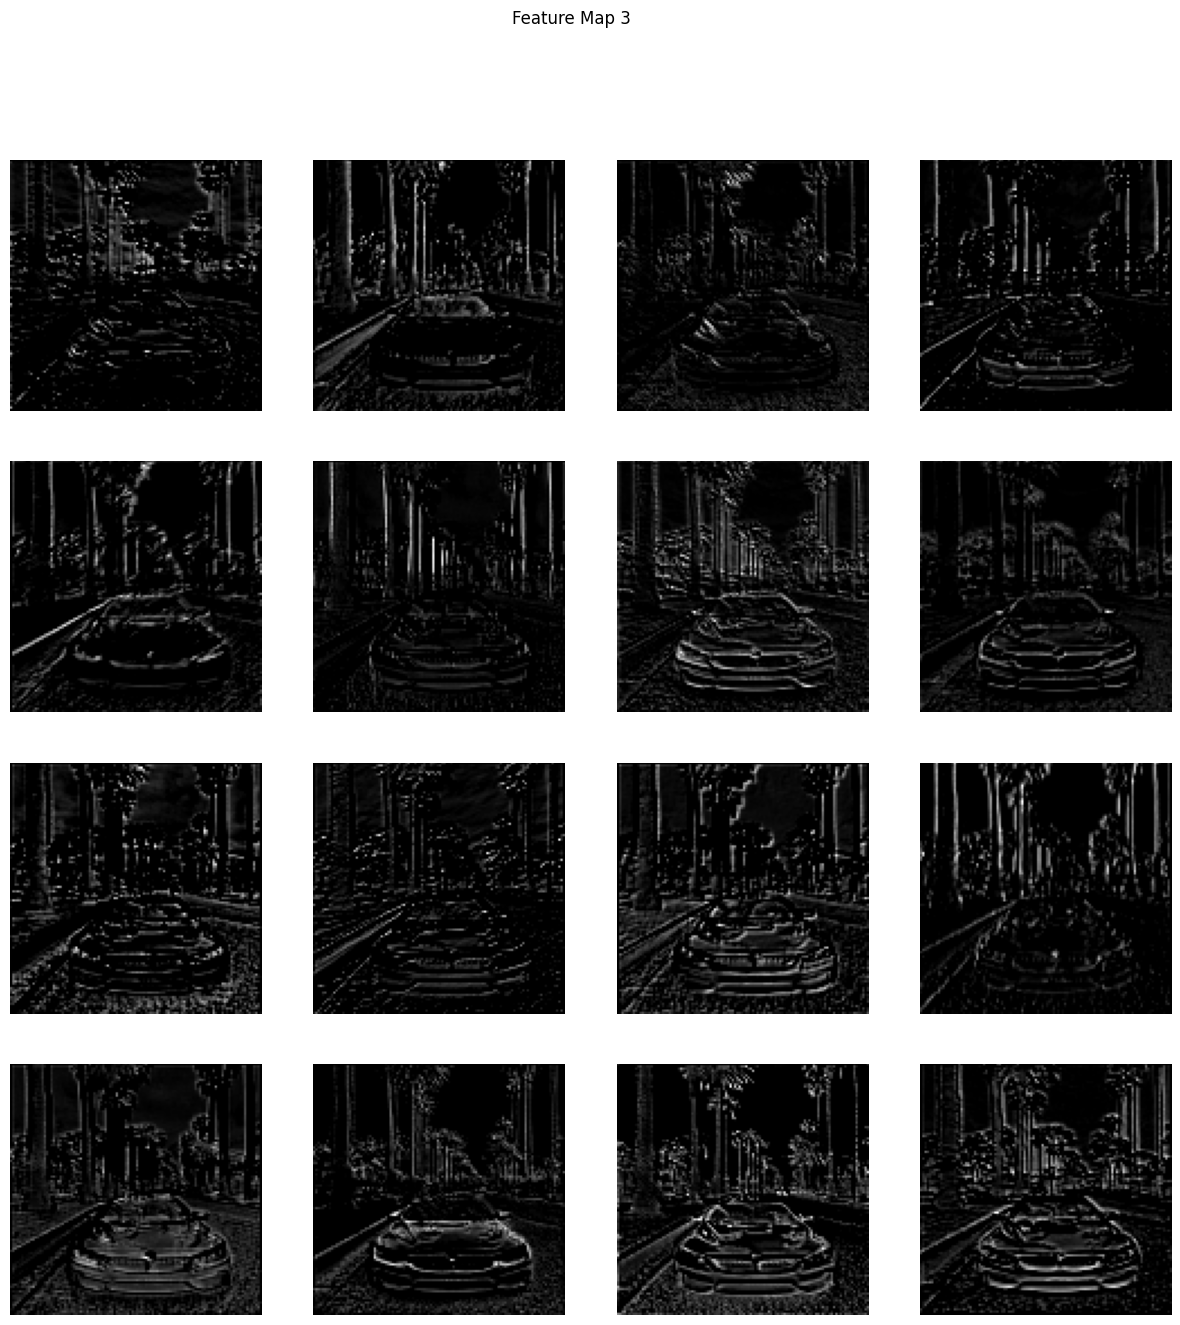

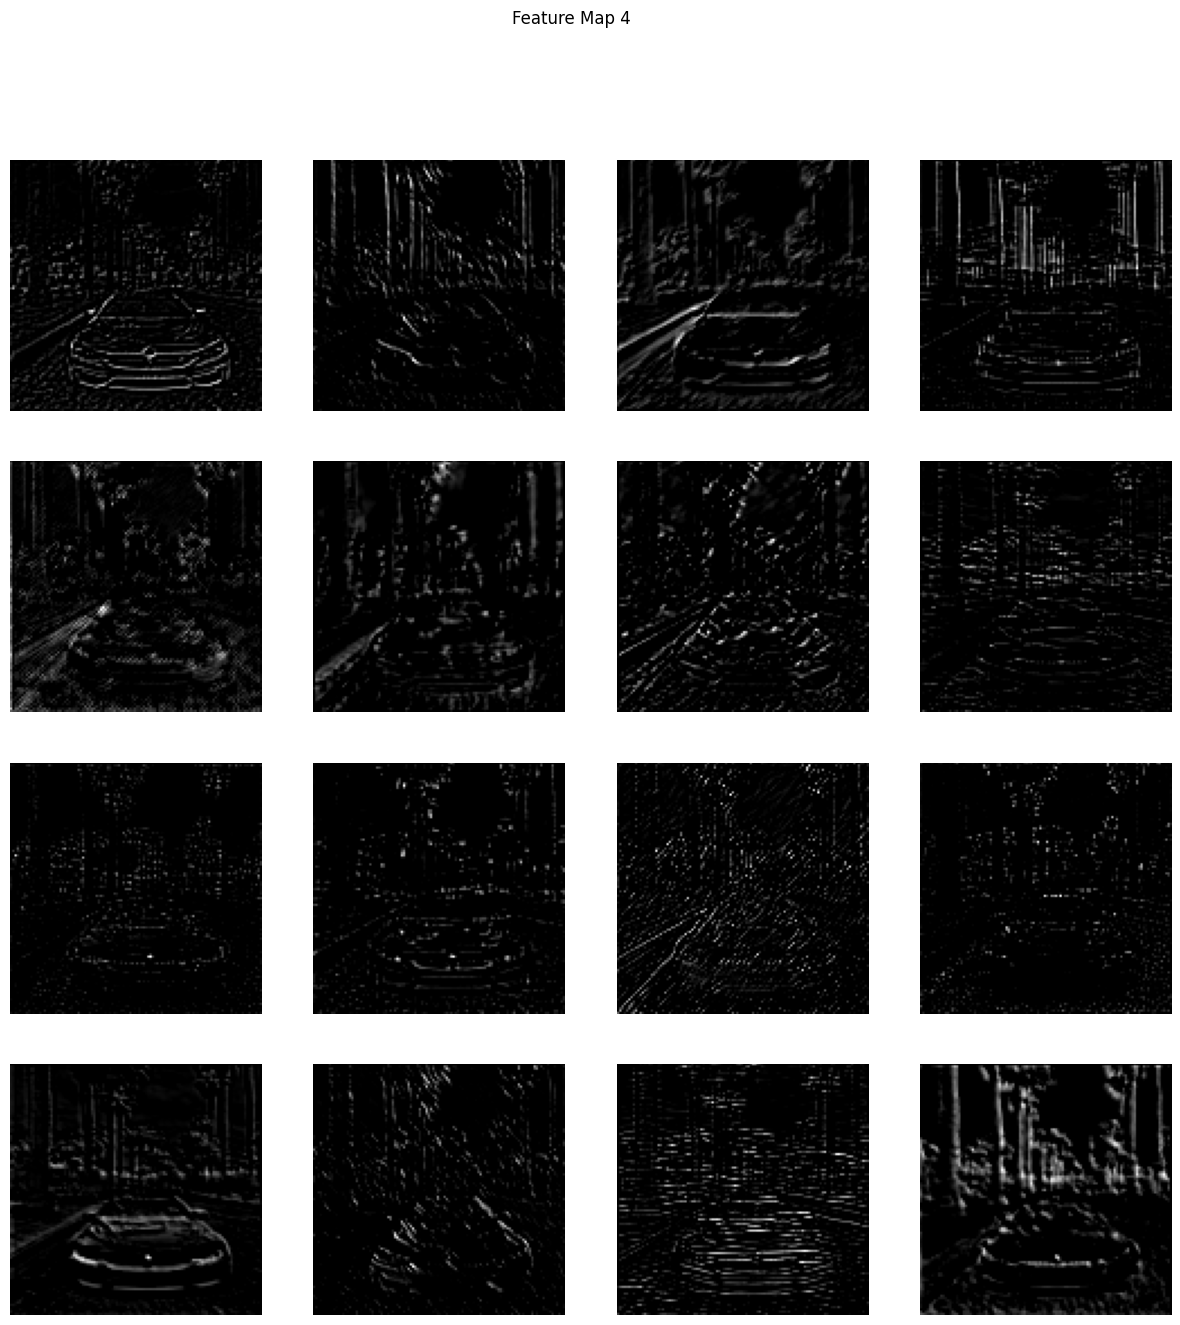

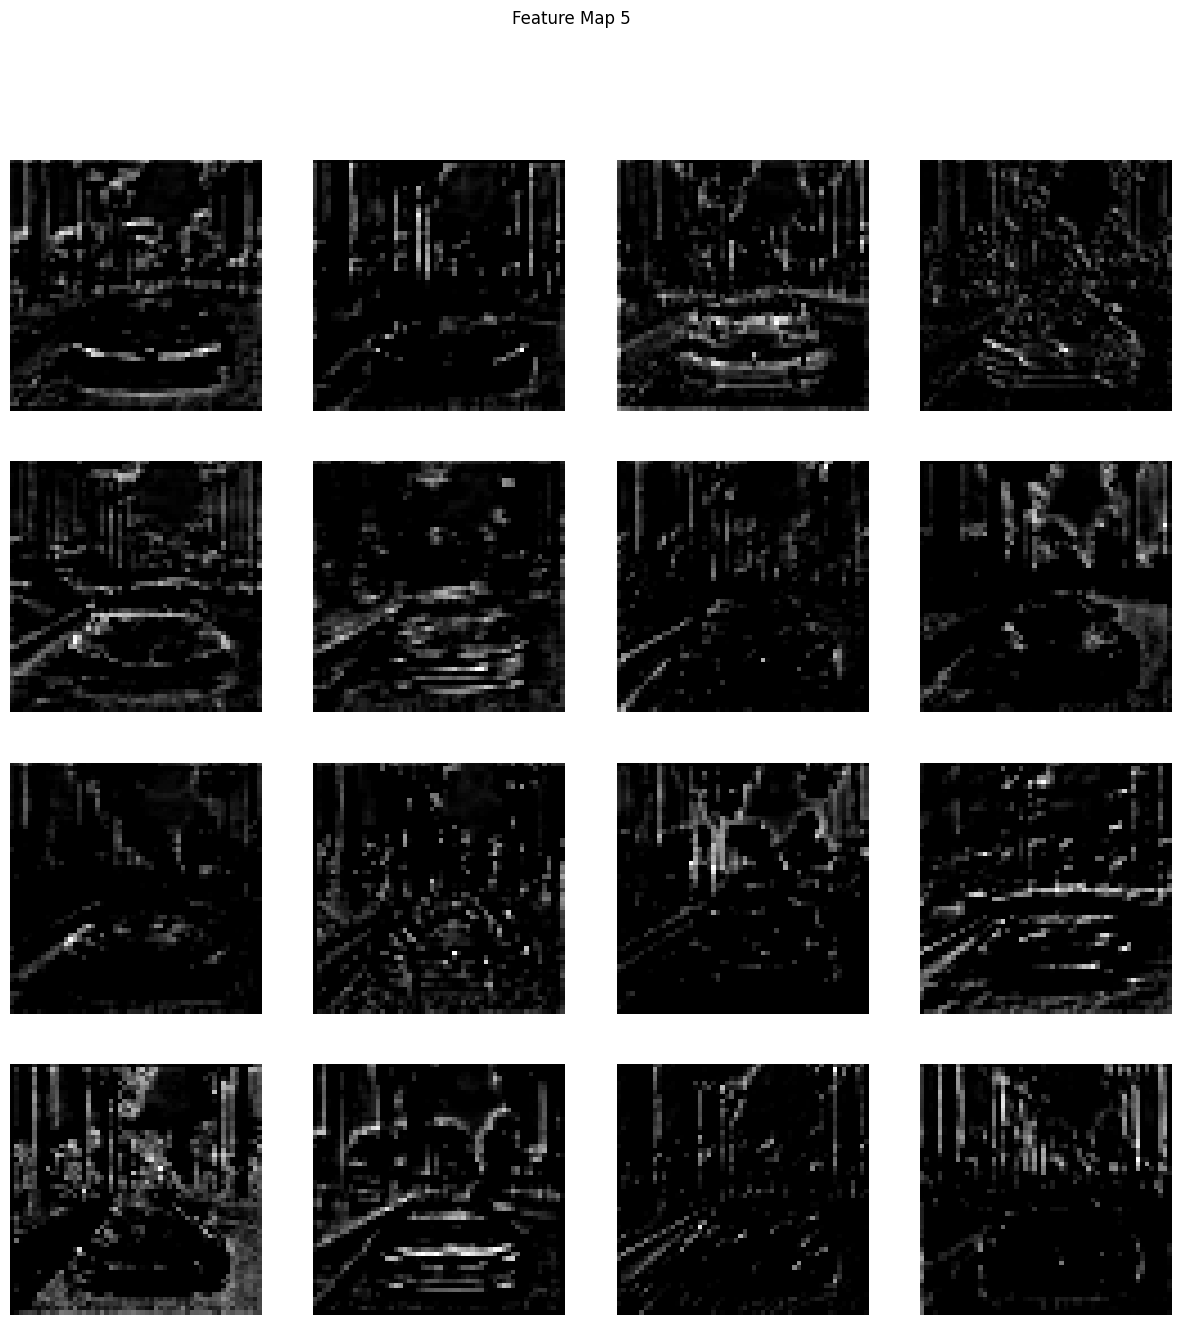

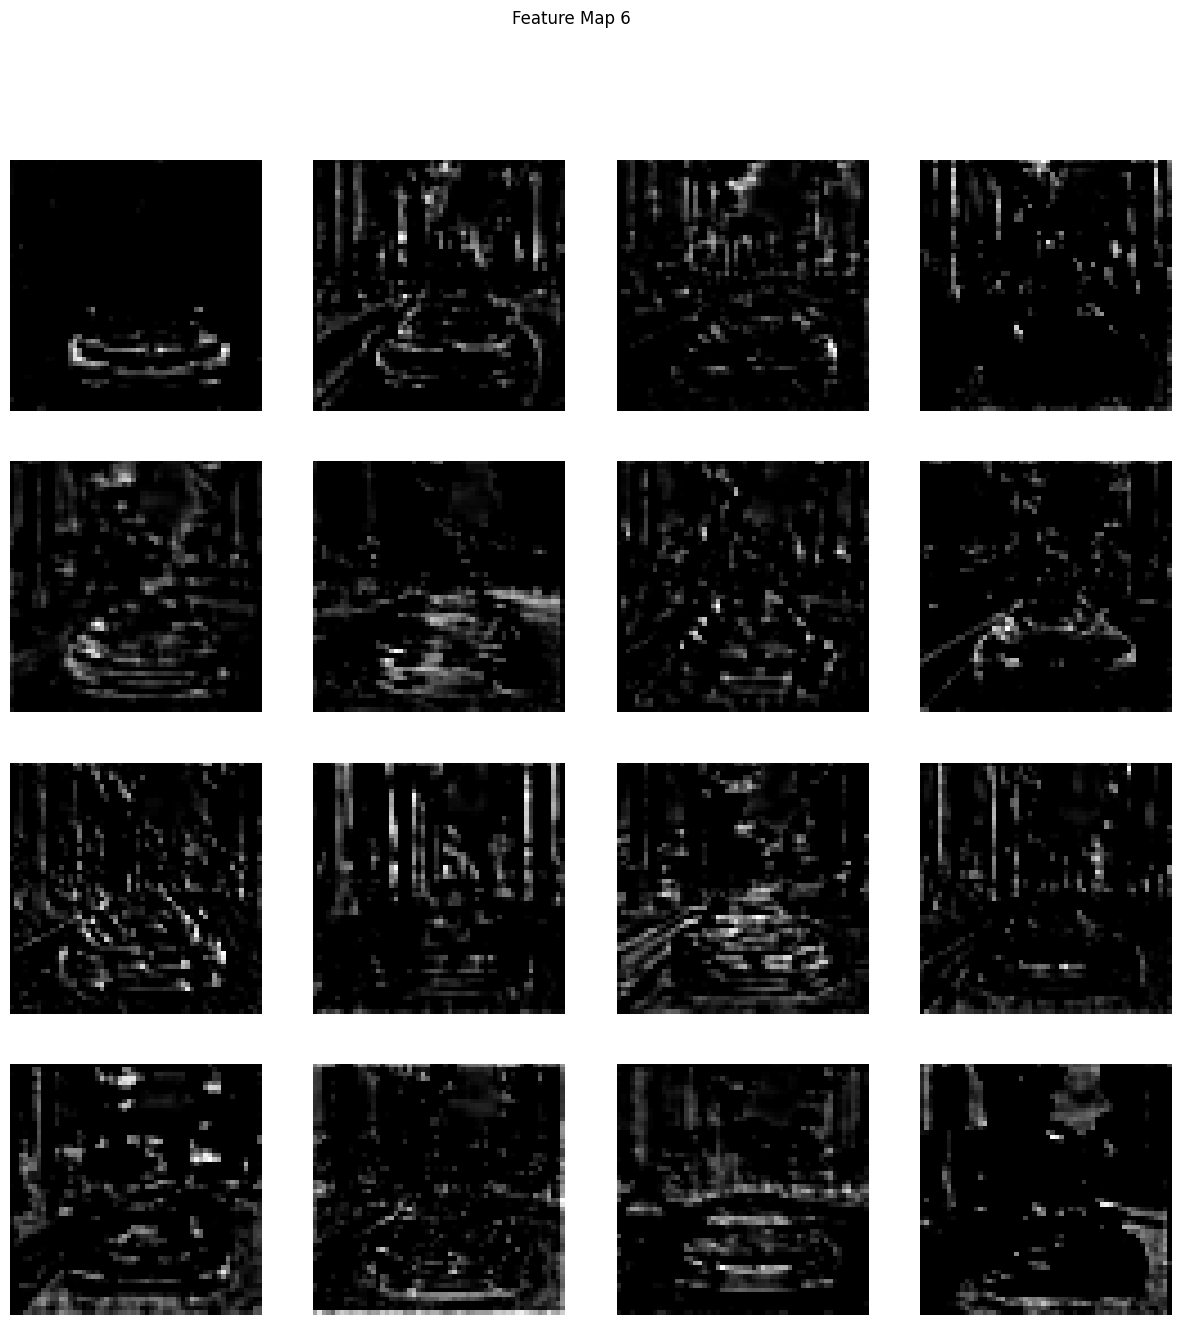

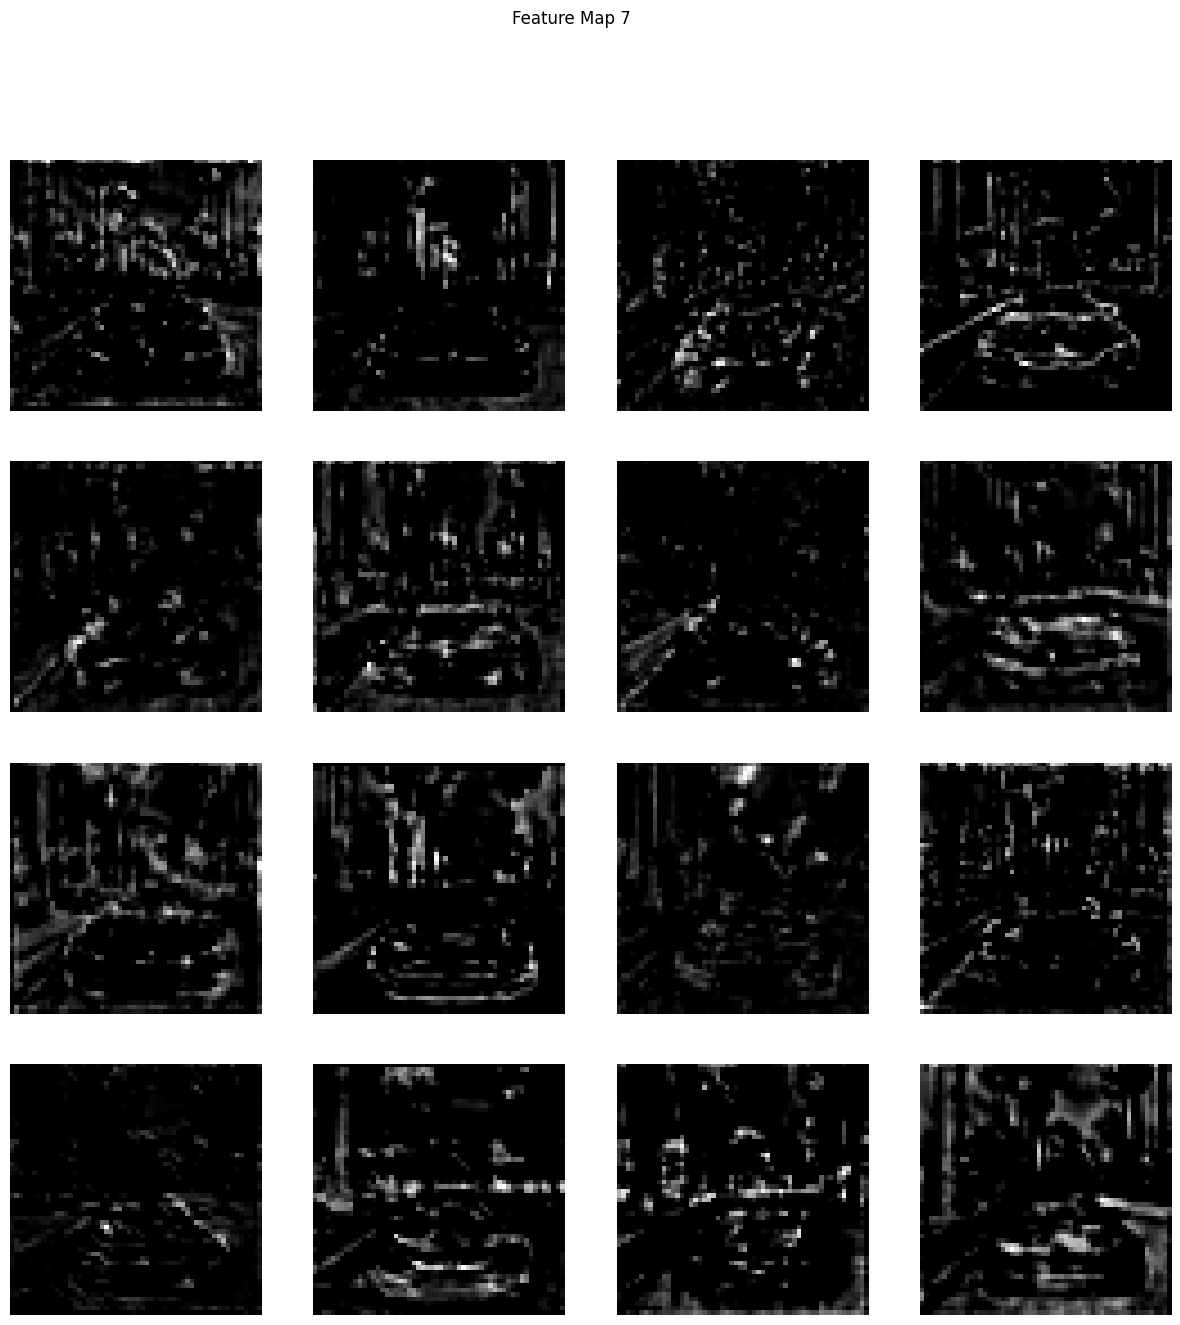

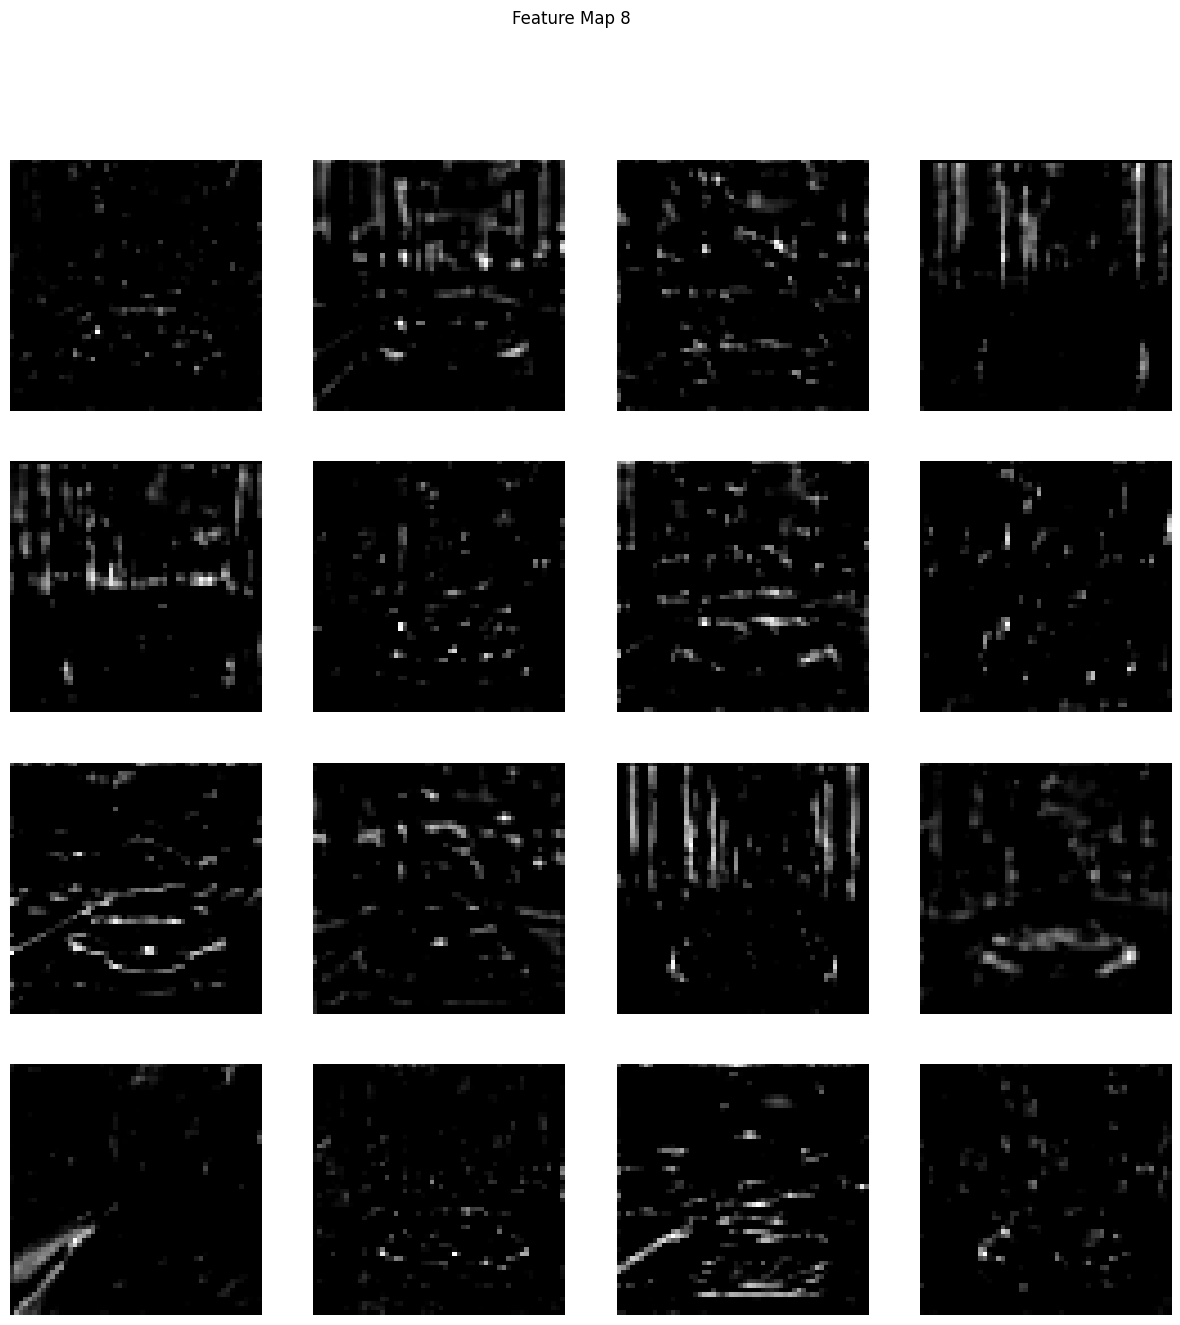

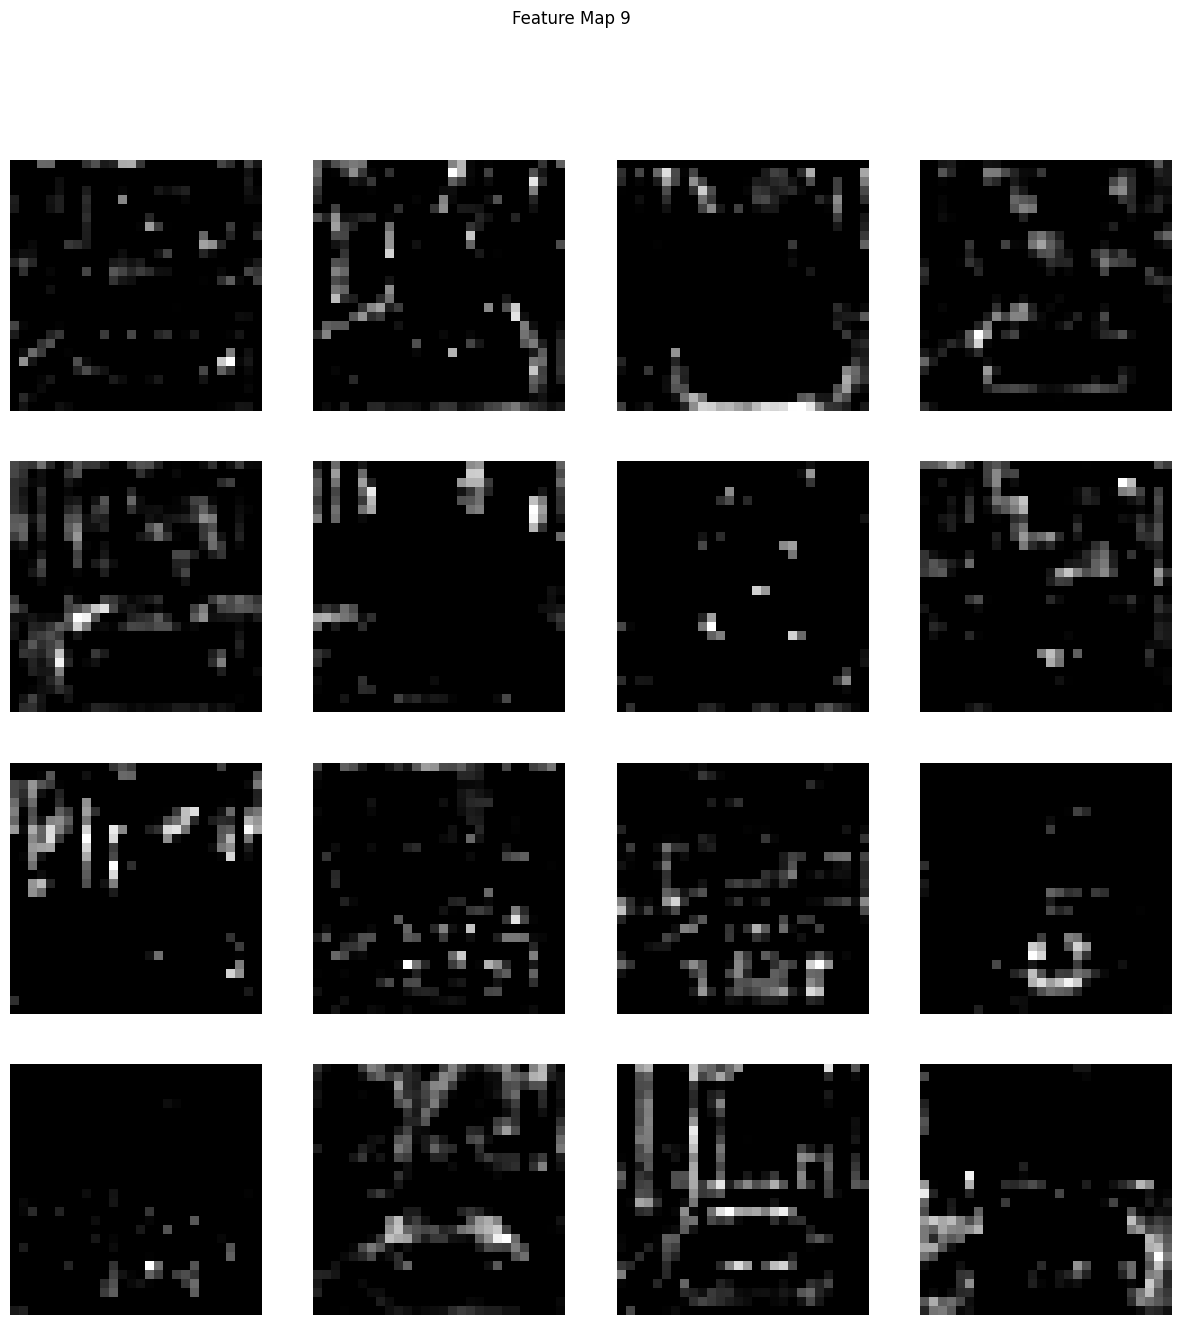

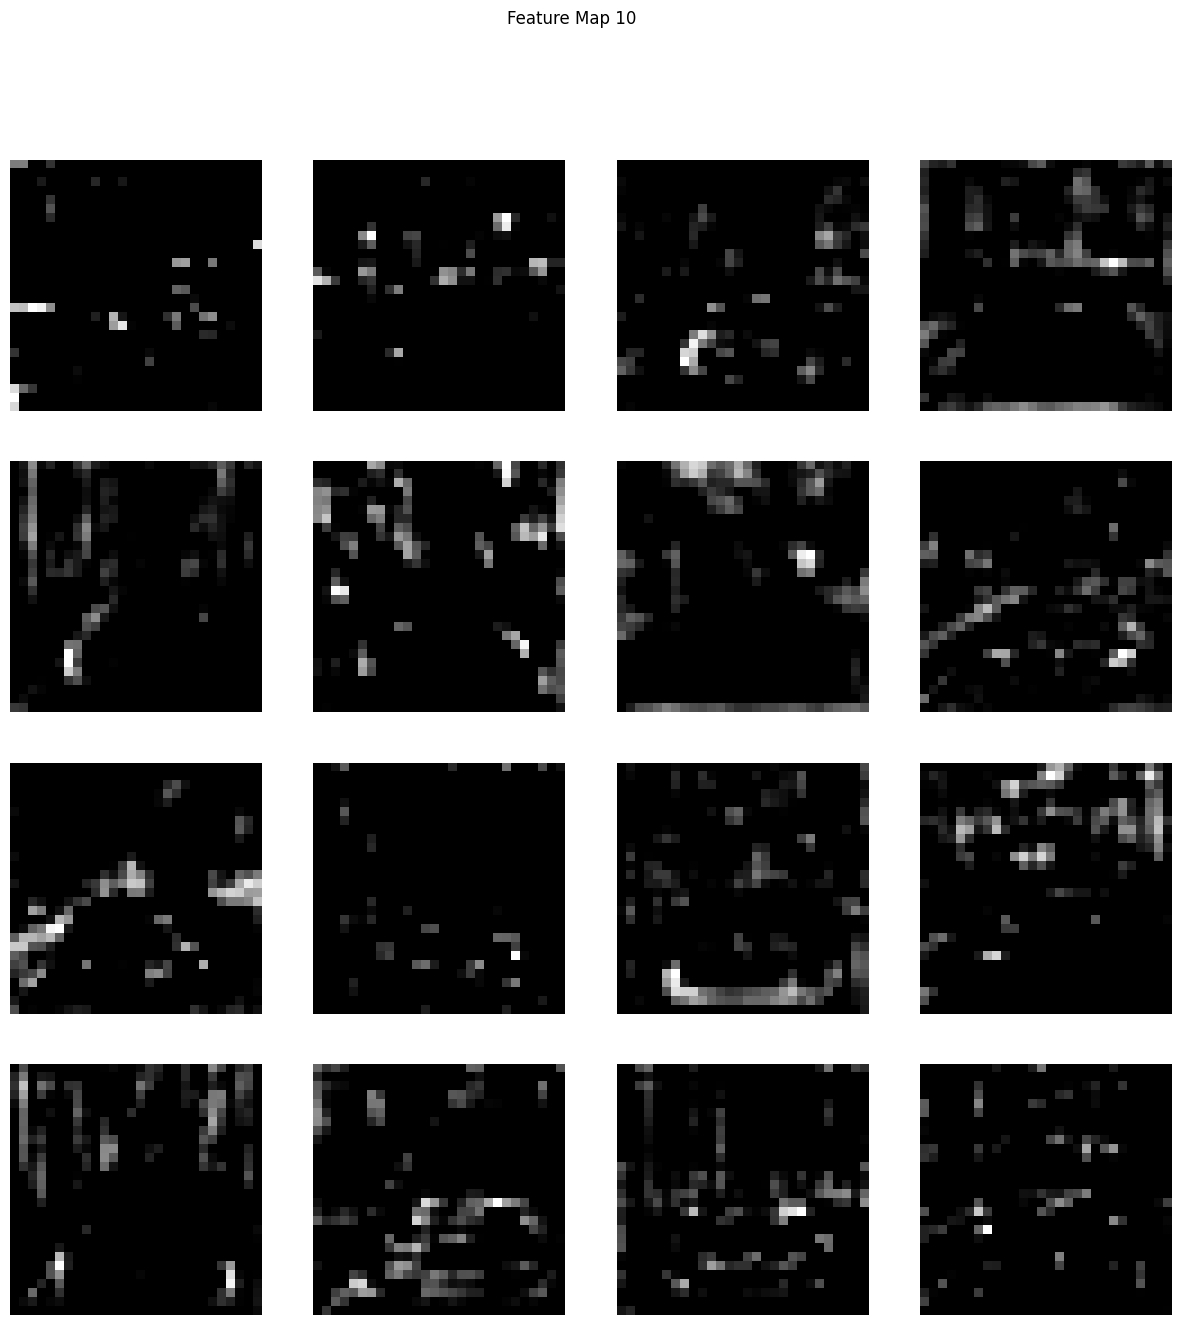

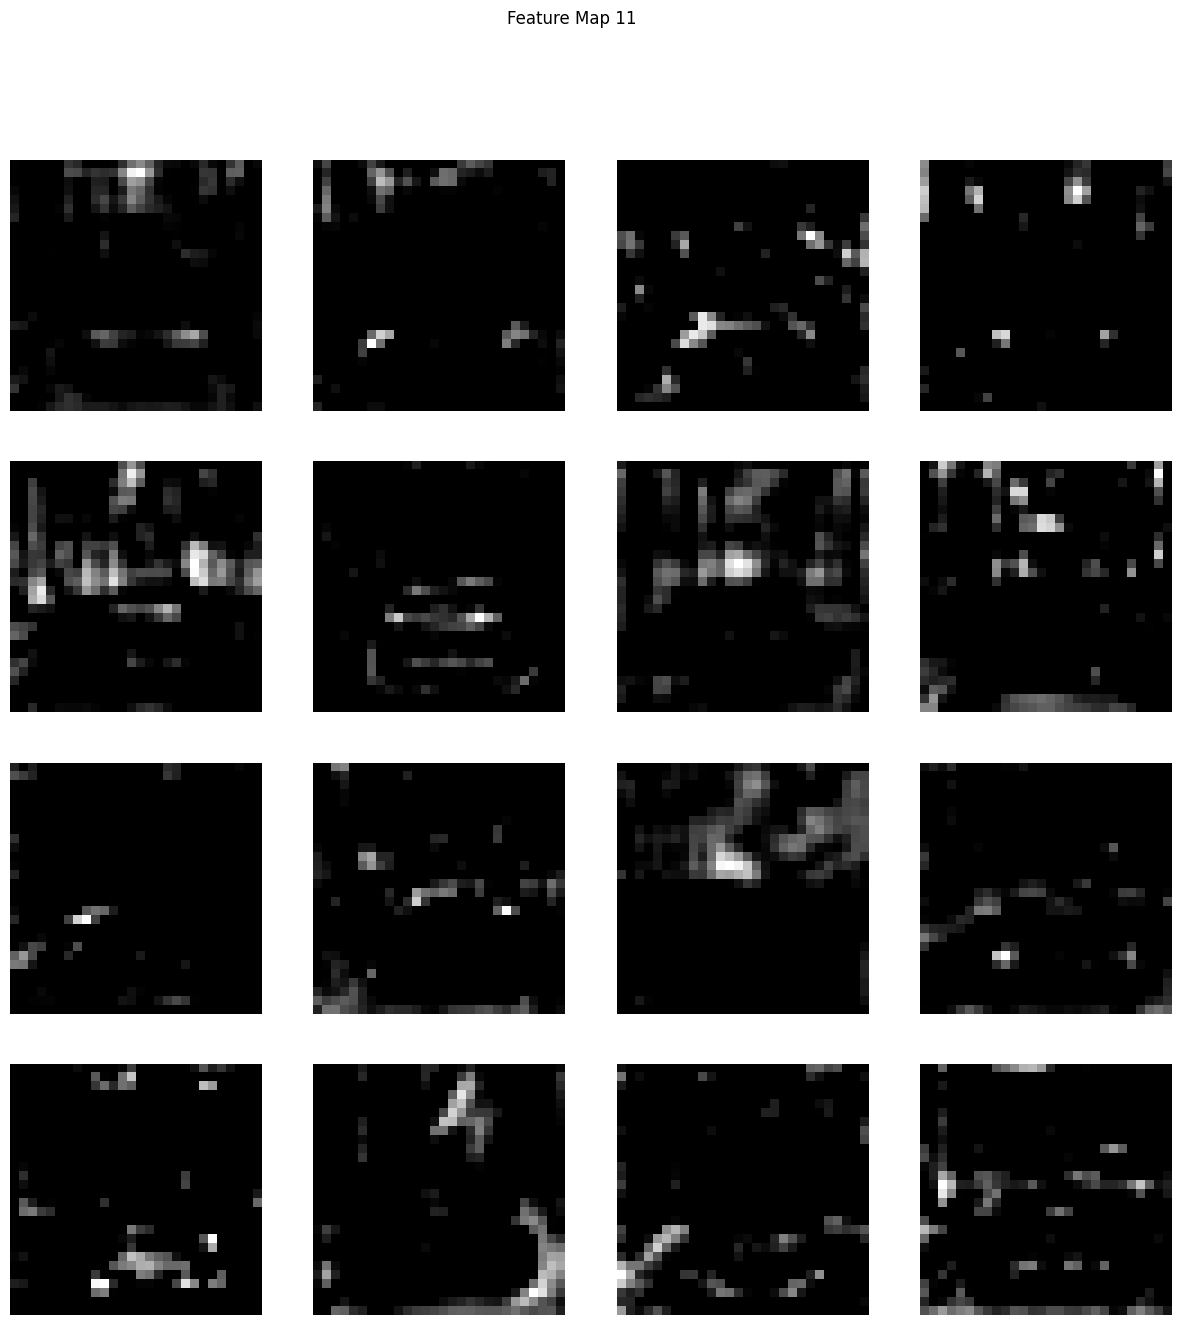

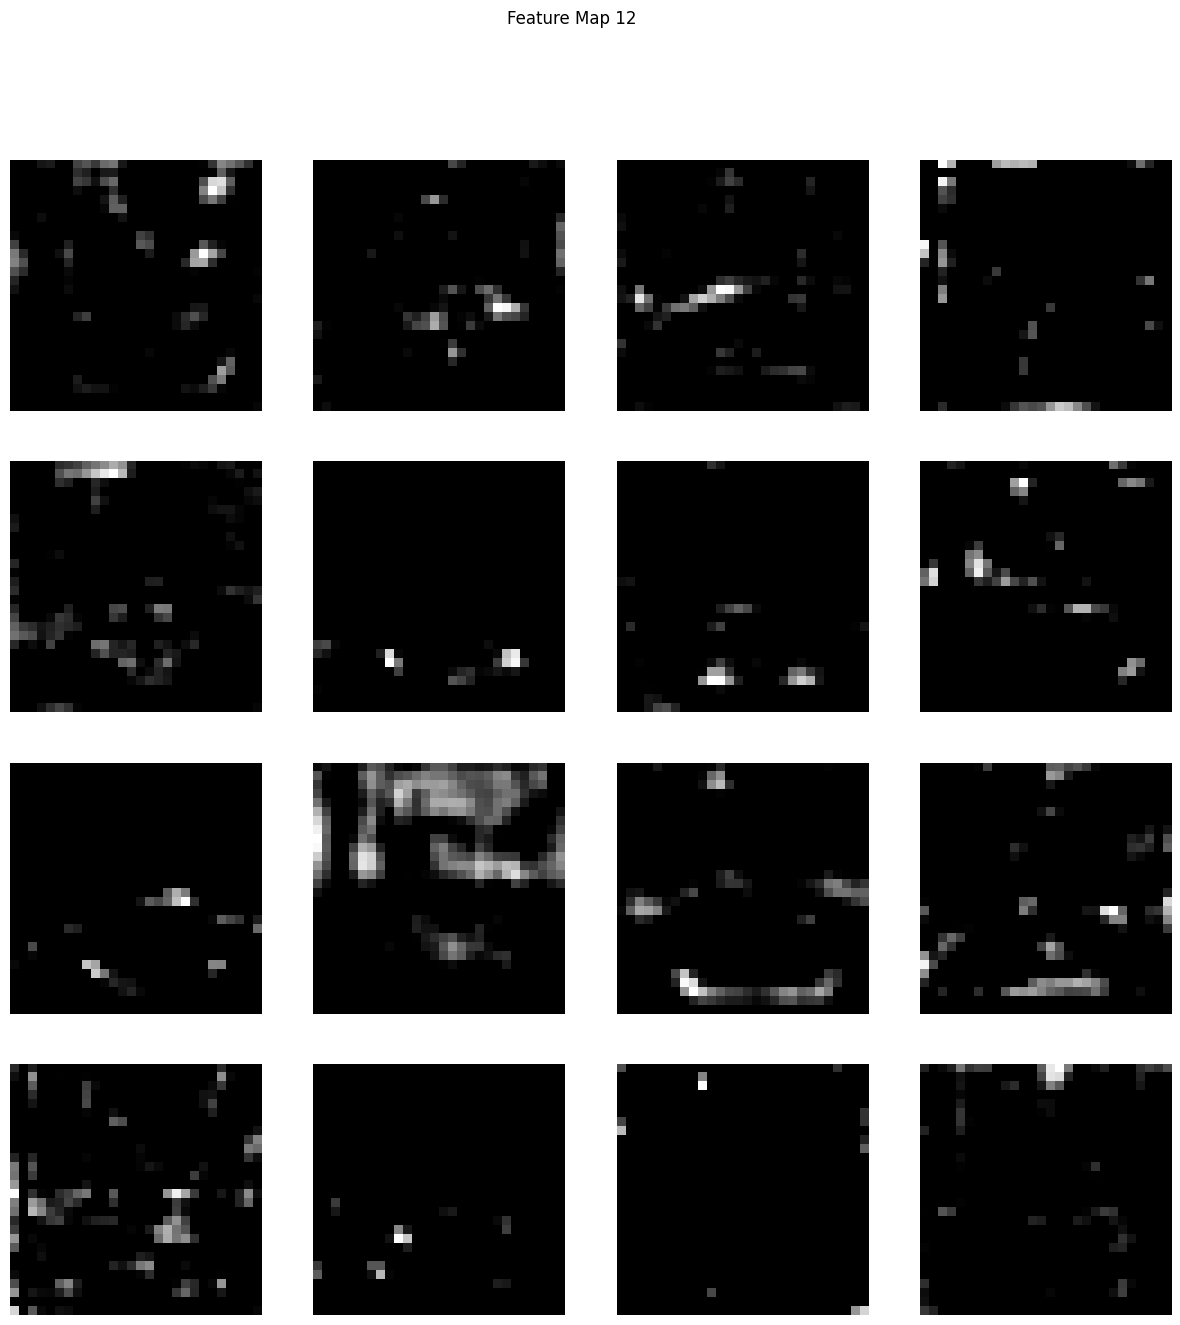

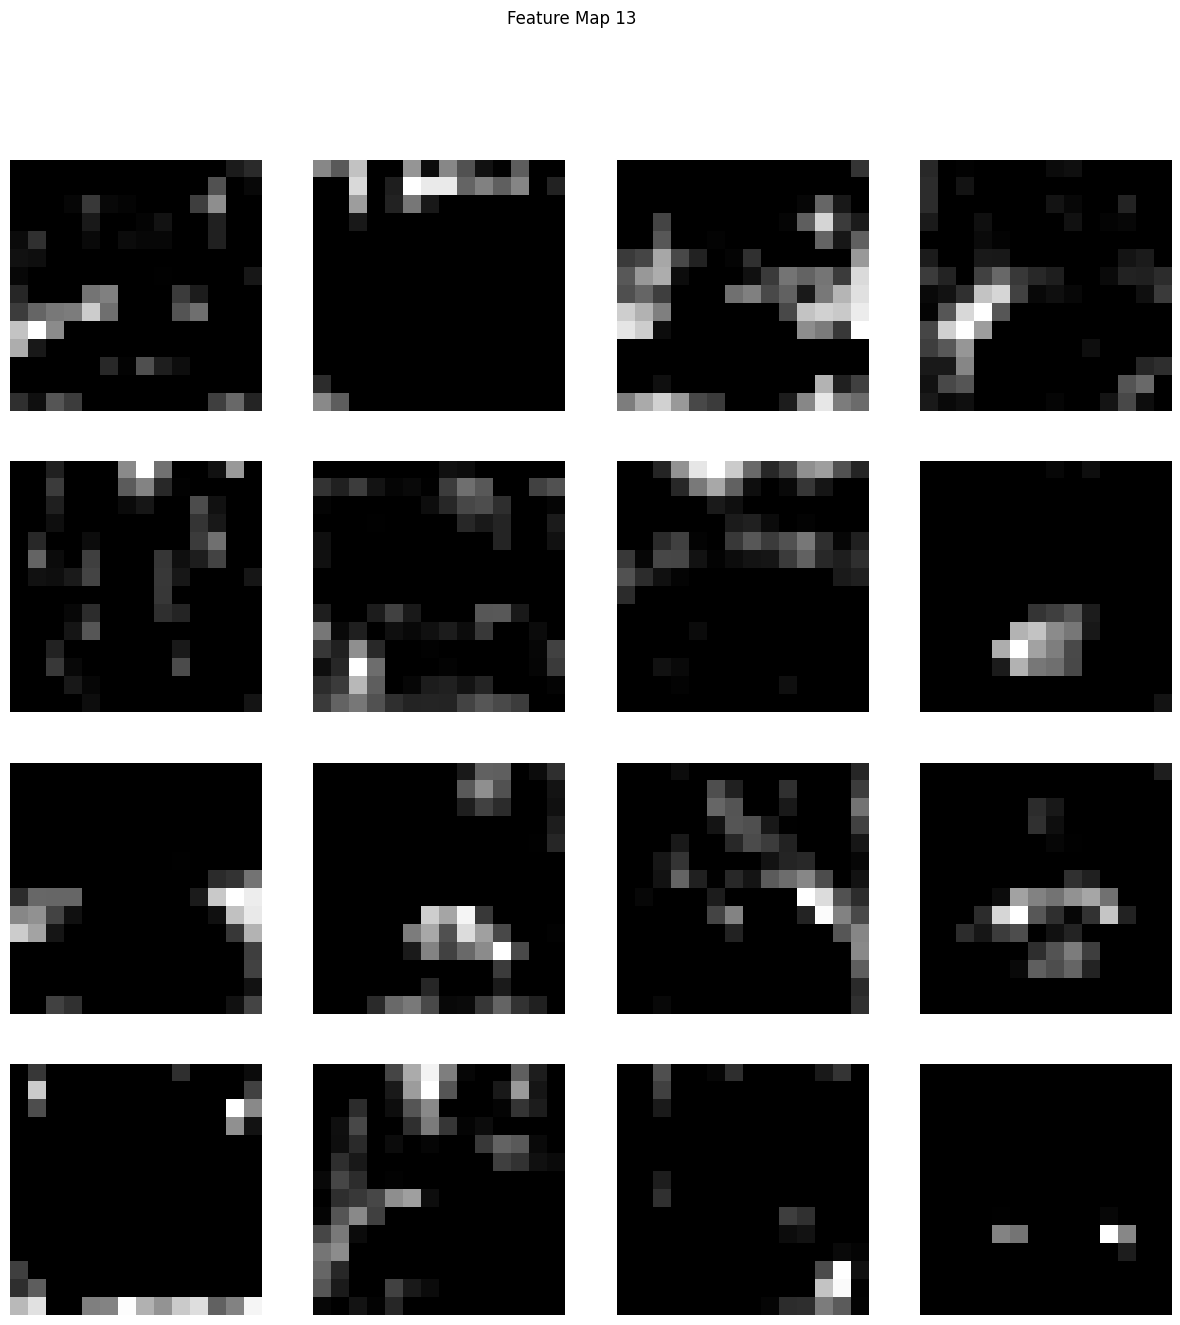

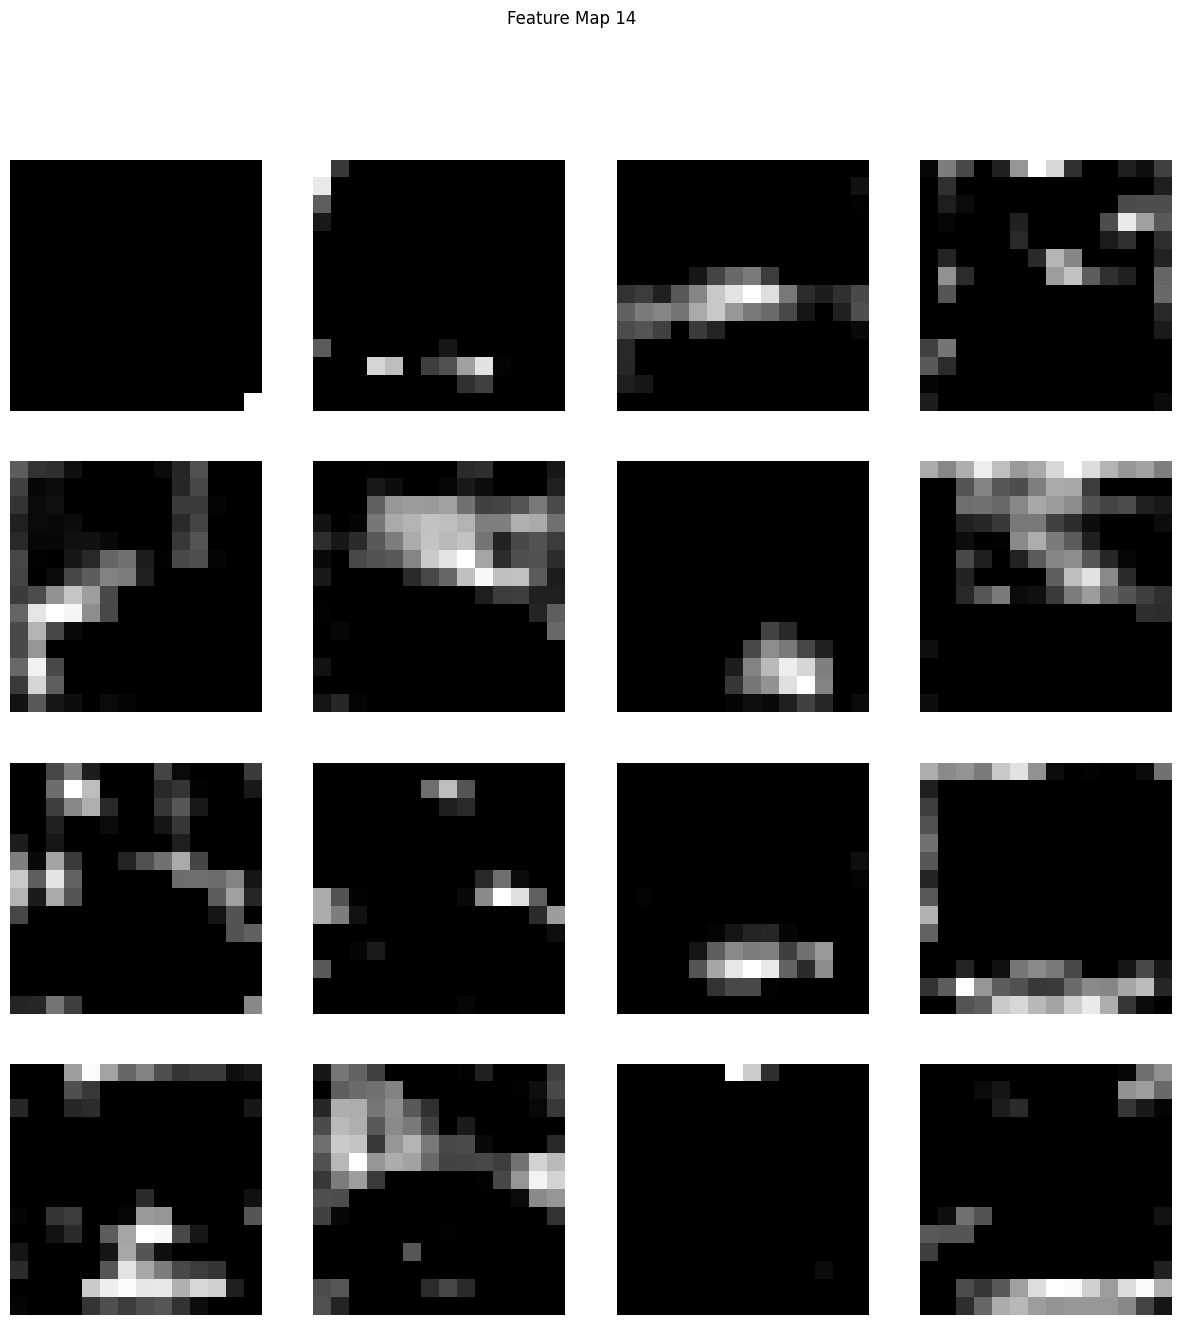

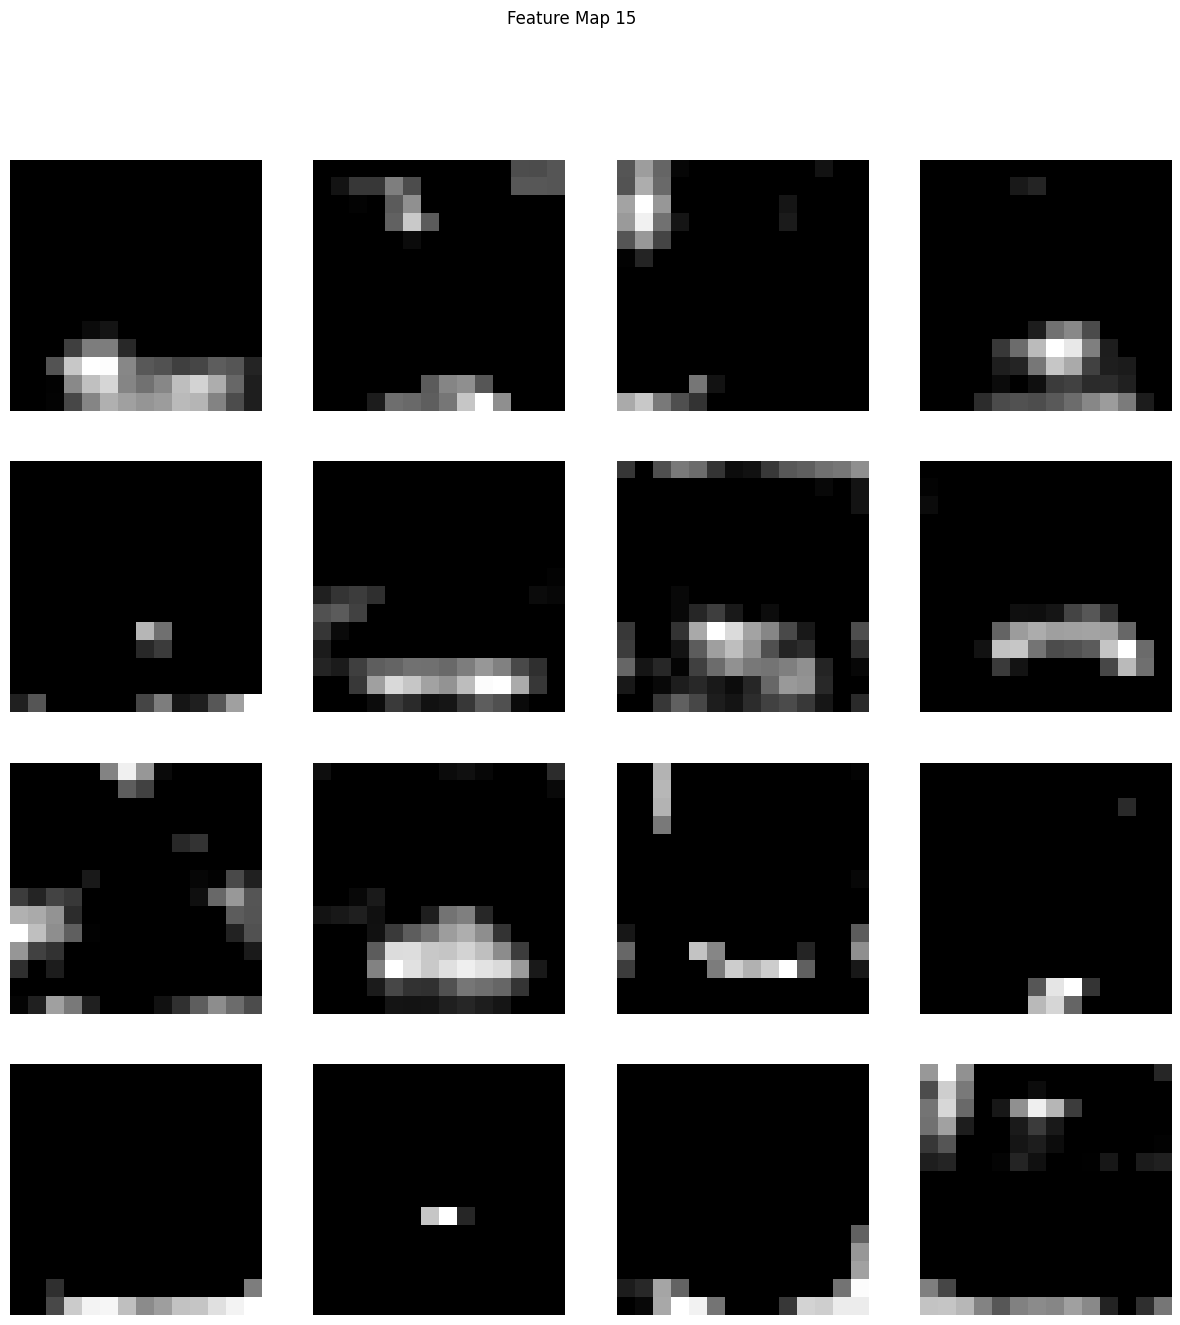

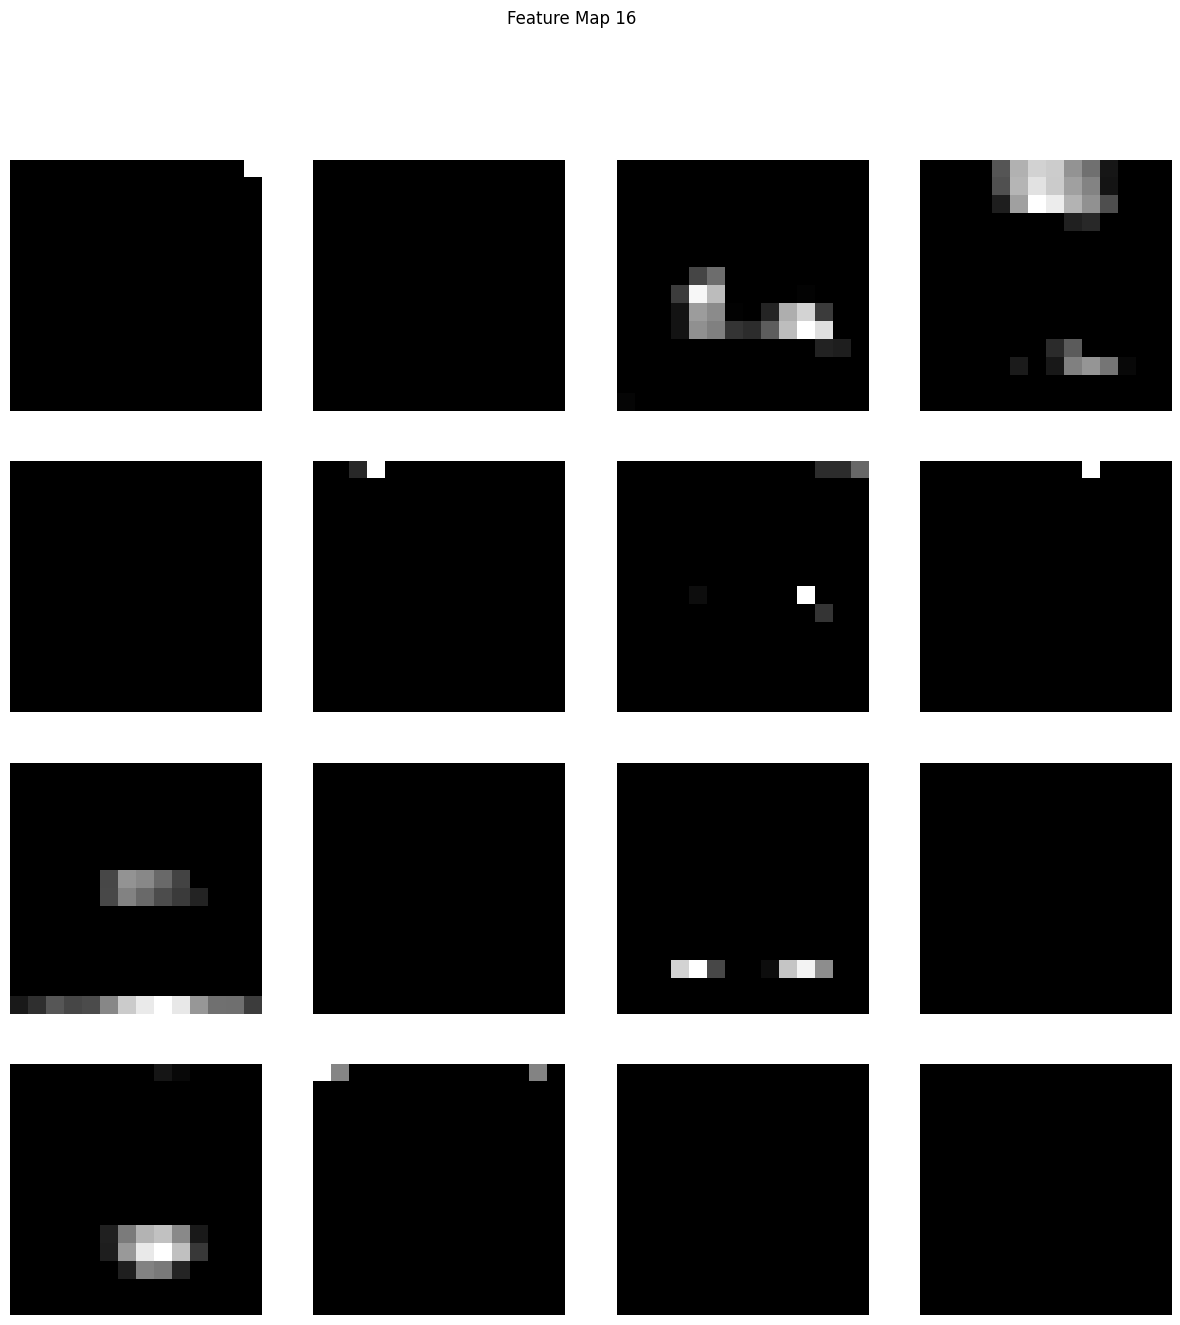

In [25]:
with torch.no_grad():
    x = input_batch
    feature_maps = []
    for layer in vgg_model.features:
        x = layer(x)
        if isinstance(layer, torch.nn.Conv2d):
            feature_maps.append(x)

# Visualize the first 16 feature maps of each Conv2D layer
for idx, fmap in enumerate(feature_maps):
    plt.figure(figsize=(15, 15))
    plt.suptitle(f'Feature Map {idx + 1}')
    for i in range(min(16, fmap.shape[1])):  # Display up to 16 feature maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(fmap[0, i].cpu(), cmap='gist_gray')
        plt.axis('off')
    plt.show()

It's fun too look under the hood, isn't it? As you can see, we can guess what are the learned features in each layer if the network (at least in the first layers). For example, in the first layer, the network learns to detect edges, and in the second layer, it learns to detect simple shapes. In the deeper layers, the network learns to detect more complex features.

In order to learn the correct image and keep the content of the original image while applying the style of the seconf image, we need 2 losses: 1. Content Loss and 2. Style Loss. Let's delve into each one!

**Content Loss** is responsible for keeping the content of the original image. It is calculated as the mean squared error between the feature maps of the original image and the generated image.

In [26]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


**Style Loss** is responsible for applying the style of the second image to the generated image. It is calculated as the mean squared error between the Gram matrices of the feature maps of the second image and the generated image.

In [27]:
def gram_calculator(input):
    """
    Calculate the normalized Gram Matrix of a given input
    """
    b, c, h, w = input.size()
    features = input.view(b, c, h * w)
    gram_matrix = torch.bmm(features, features.transpose(1, 2))
    gram_matrix = gram_matrix / (b * c * h * w)
    return gram_matrix


In [28]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_calculator(target_feature).detach()  # Calculate and store the Gram matrix of the target feature

    def forward(self, input):
        G = gram_calculator(input)  # Calculate the Gram matrix of the input
        self.loss = F.mse_loss(G, self.target)  # Calculate the mean squared error between the Gram matrices
        return input


Now, we use `features` part of the VGG model to extract features from the content and style images. Then, we calculate the content and style loss using the extracted features.

In [29]:
cnn = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

I should note after which layers I will calculate the content loss and after which ones I will calculate the style loss. I will use the layer names observed earlier in the `torchsummary` output for the VGG19 model.


In [30]:
default_content_layers = ['conv4']
default_style_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

def compute_loss_layers(cnn_model, style_image, content_image):
    # Define the normalization using the precomputed mean and std
    normalization_transform = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std).to(device)
    model_sequence = nn.Sequential(normalization_transform)

    content_loss_layers = []
    style_loss_layers = []

    layer_index = 0
    for layer in cnn_model.children():
        if isinstance(layer, nn.Conv2d):
            layer_index += 1
            layer_name = f'conv{layer_index}'
        elif isinstance(layer, nn.ReLU):
            layer_name = f'relu{layer_index}'
            layer = nn.ReLU(inplace=False)
        else:
            layer_name = f'other{layer_index}'

        model_sequence.add_module(layer_name, layer)

        if layer_name in default_content_layers:
            target_feature = model_sequence(content_image).detach()
            content_loss_layer = ContentLoss(target_feature)
            model_sequence.add_module(f'content_loss_{layer_index}', content_loss_layer)
            content_loss_layers.append(content_loss_layer)

        if layer_name in default_style_layers:
            target_feature = model_sequence(style_image).detach()
            style_loss_layer = StyleLoss(target_feature)
            model_sequence.add_module(f'style_loss_{layer_index}', style_loss_layer)
            style_loss_layers.append(style_loss_layer)

    # Find the position of the last loss layers
    final_content_loss_idx = max(idx for idx, layer in enumerate(model_sequence) if isinstance(layer, ContentLoss))
    final_style_loss_idx = max(idx for idx, layer in enumerate(model_sequence) if isinstance(layer, StyleLoss))
    final_loss_idx = max(final_content_loss_idx, final_style_loss_idx)

    # Truncate the model to include layers up to the last loss layer
    model_sequence = model_sequence[:final_loss_idx + 1]

    return model_sequence, content_loss_layers, style_loss_layers

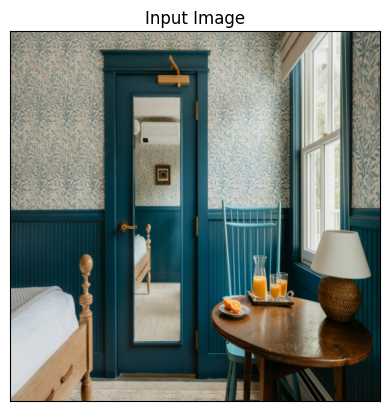

In [31]:
imshow(content_image, title='Input Image')

Now, I need to define the optimizer. I will use the `LBFGS` optimizer. To get familiar with it, I will apply it to a simple function: \( f(x) = x^2 \). The goal is to find the minimum of this function using the `LBFGS` optimizer.  

First, I will initialize a tensor \( x \) with a random value. Then, I will define a closure function that computes both the function value and its gradient. Finally, I will use the `step` method of the optimizer to update the value of \( x \).  

Lastly, I will generate an animation using `matplotlib.animation` to illustrate how the value of \( x \) changes during the optimization process.


/usr/local/lib/python3.12/dist-packages/torch/utils/_device.py:103: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return func(*args, **kwargs)


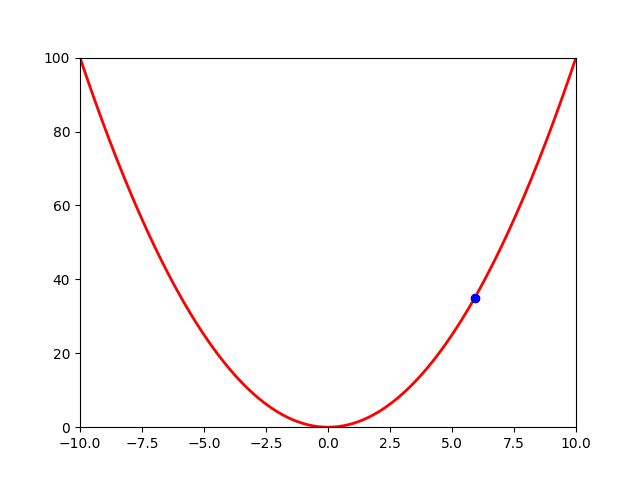

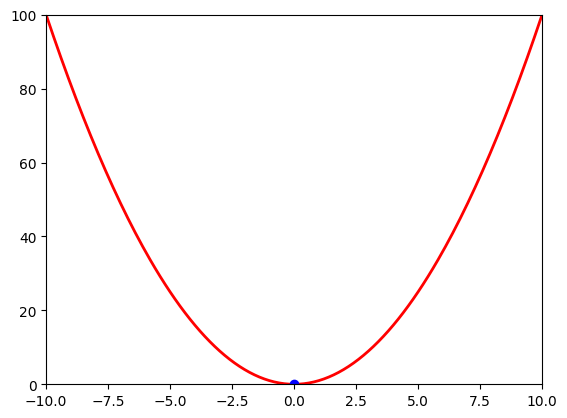

In [32]:
import torch
from torch.optim import LBFGS
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image as disimage, display
import random

# Define the quadratic function f(x) = x^2
def quadratic_function(x):
    return x ** 2

# Initialize a tensor with a single random value (e.g., between 5.0 and 10.0)
x = torch.tensor([random.uniform(5.0, 10.0)], requires_grad=True)

# Define the optimizer
optimizer = LBFGS([x], lr=0.1, max_iter=15)
x_values = []

# Define the closure function for the optimizer
def closure():
    optimizer.zero_grad()
    loss = quadratic_function(x)
    loss.backward()
    x_values.append(x.item())
    return loss

# Optimization loop
for _ in range(20):  # Run for a few iterations
    optimizer.step(closure)

# Generate the animation
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-', lw=2)  # Red line for the function plot
dot, = ax.plot([], [], 'bo')         # Blue dot for the current x value

ax.set_xlim(-10, 10)
ax.set_ylim(0, 100)

def init():
    line.set_data([], [])
    dot.set_data([], [])
    return line, dot

def update(num):
    x_plot = [i / 10.0 for i in range(-100, 101)]
    y_plot = [quadratic_function(torch.tensor([xi])).item() for xi in x_plot]
    line.set_data(x_plot, y_plot)
    dot.set_data([x_values[num]], [x_values[num] ** 2])
    return line, dot

ani = animation.FuncAnimation(fig, update, frames=len(x_values), init_func=init, blit=True)

# Save the animation as a GIF using Pillow writer
ani.save('animation.gif', writer='pillow')

# Display the saved animation
display(disimage(filename='animation.gif'))


Now, I will use this optimizer to optimize the `input_image` in order to minimize the content and style loss. I will define a closure function that computes both the content and style loss along with their gradients. Then, I will apply the `step` method of the optimizer to update the value of the `input_image`.  

I should also note that I will use a weighted sum of the content and style loss to optimize the input image, where the weight of each loss is treated as a hyperparameter.


Iteration 1:
Content Loss: 0.0
Style Loss: 2810.497802734375
Total Loss: 2810.497802734375


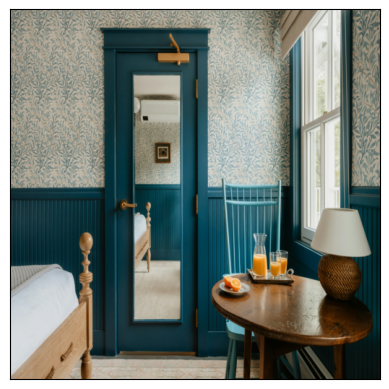

Iteration 51:
Content Loss: 17.986865997314453
Style Loss: 90.18589782714844
Total Loss: 108.17276000976562


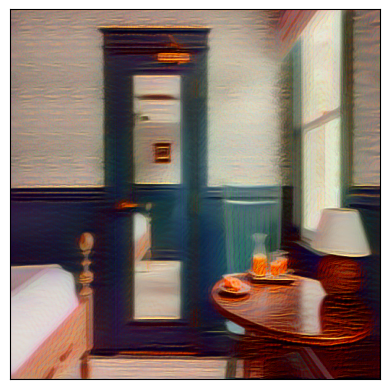

Iteration 101:
Content Loss: 18.159265518188477
Style Loss: 39.58980178833008
Total Loss: 57.74906921386719


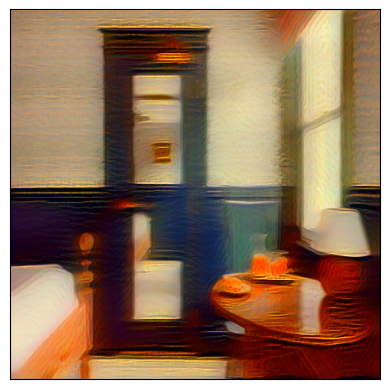

Iteration 151:
Content Loss: 16.510379791259766
Style Loss: 40.909671783447266
Total Loss: 57.42005157470703


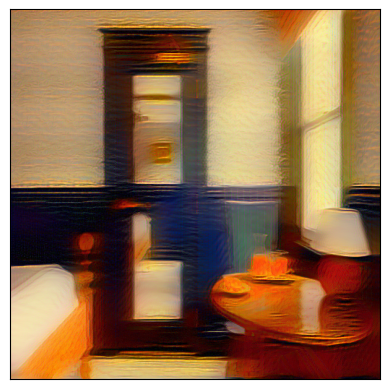

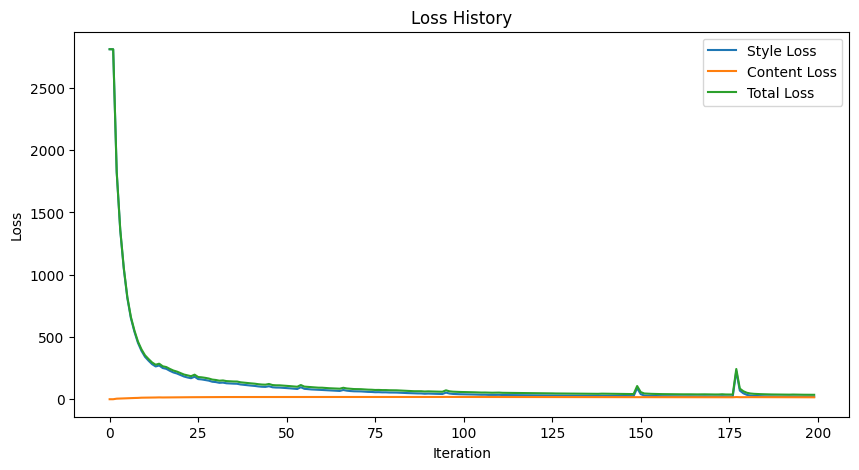

In [33]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust the style and content weights to be comparable
alpha = 1  # weight for content loss
beta = 350000  # weight for style loss

input_image = unnormalize(content_image).clone()
model, content_losses, style_losses = compute_loss_layers(cnn, unnormalize(style_image), unnormalize(content_image))

input_image = input_image.to(device)
model = model.to(device)
for cl in content_losses:
    cl.to(device)
for sl in style_losses:
    sl.to(device)

optimizer = optim.LBFGS([input_image.requires_grad_()])

num_iterations = 200
style_loss_history = []
content_loss_history = []
total_loss_history = []

# Use a global variable for iteration
global iteration
iteration = 0

def closure():
    global iteration  # Ensure we update the outer scope counter
    if iteration >= num_iterations:
        return
    optimizer.zero_grad()
    model(input_image)

    content_loss = 0
    style_loss = 0

    for cl in content_losses:
        content_loss += cl.loss
    for sl in style_losses:
        style_loss += sl.loss

    style_loss = beta * style_loss
    content_loss = alpha * content_loss

    total_loss = content_loss + style_loss
    total_loss.backward()

    style_loss_history.append(style_loss.item())
    content_loss_history.append(content_loss.item())
    total_loss_history.append(total_loss.item())

    iteration += 1  # Increment iteration counter

    with torch.no_grad():
        input_image.clamp_(0, 1)

    if iteration % 50 == 1:
        print(f"Iteration {iteration}:")
        print(f"Content Loss: {content_loss_history[-1]}")
        print(f"Style Loss: {style_loss_history[-1]}")
        print(f"Total Loss: {total_loss_history[-1]}")
        imshow(input_image.cpu(), normalized=False)

    return total_loss

while iteration < num_iterations:
    optimizer.step(closure)

plt.figure(figsize=(10, 5))
plt.plot(style_loss_history, label='Style Loss')
plt.plot(content_loss_history, label='Content Loss')
plt.plot(total_loss_history, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.show()


Now, let's see the result of optimization process on our `input_image`.

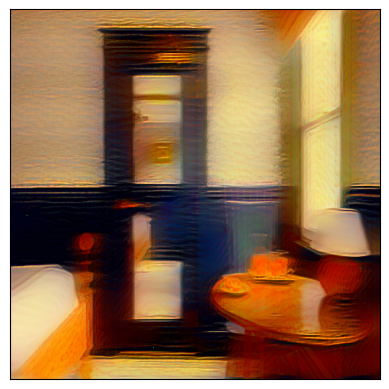

In [34]:
# Plot the final result
plt.figure()
imshow(input_image.cpu(), normalized=False)

Also, let's plot our `style_losses`, `content_losses` and `total_losses` to see how they change during the optimization process.

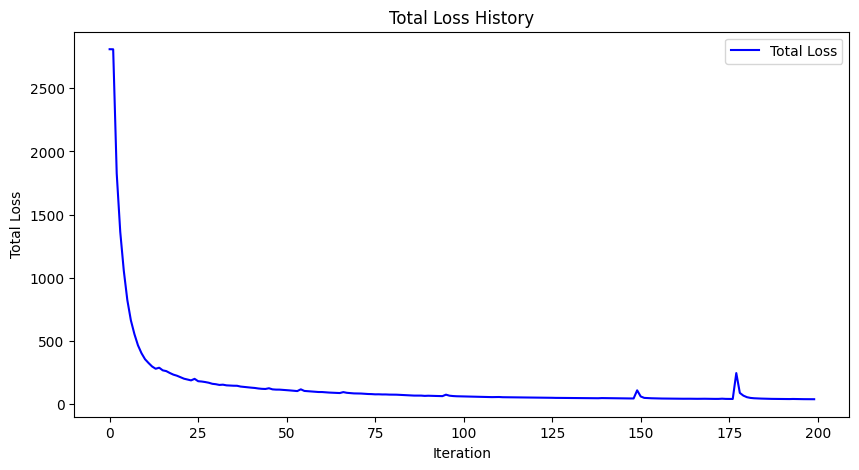

In [35]:
# Plot Total Loss
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.legend()
plt.title('Total Loss History')
plt.show()


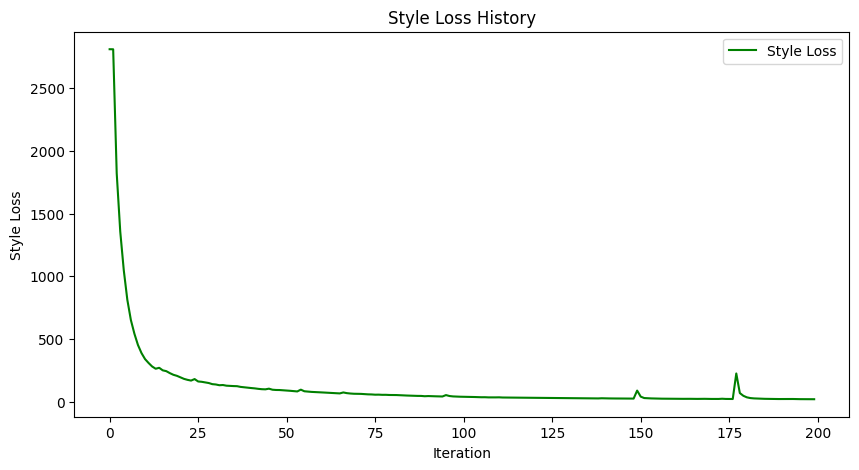

In [36]:
# Plot Style Loss
plt.figure(figsize=(10, 5))
plt.plot(style_loss_history, label='Style Loss', color='green')
plt.xlabel('Iteration')
plt.ylabel('Style Loss')
plt.legend()
plt.title('Style Loss History')
plt.show()


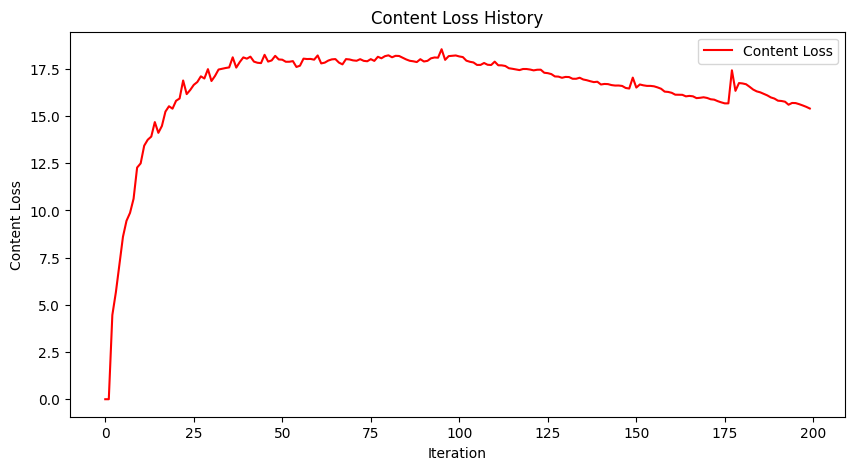

In [37]:
# Plot Content Loss
plt.figure(figsize=(10, 5))
plt.plot(content_loss_history, label='Content Loss', color='red')
plt.xlabel('Iteration')
plt.ylabel('Content Loss')
plt.legend()
plt.title('Content Loss History')
plt.show()
